# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=2, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD004.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   42.0049    0.8400  549.68  1343.43  1112.93  137.36  2211.86   
1   1      2   20.0020    0.7002  606.07  1477.61  1237.50  332.10  2323.66   
2   1      3   42.0038    0.8409  548.95  1343.12  1117.05  138.18  2211.92   
3   1      4   42.0000    0.8400  548.70  1341.24  1118.03  137.98  2211.88   
4   1      5   25.0063    0.6207  536.10  1255.23  1033.59  174.82  1915.22   

        s9    s11     s12      s13      s14      s15  s17    s20      s21  
0  8311.32  41.69  129.78  2387.99  8074.83   9.3335  330  10.62   6.3670  
1  8713.60  43.94  312.59  2387.73  8046.13   9.1913  361  24.37  14.6552  
2  8306.69  41.66  129.62  2387.97  8066.62   9.4007  329  10.48   6.4213  
3  8312.35  41.68  129.80  2388.02  8076.05   9.3369  328  10.54   6.4176  
4  7994.94  36.48  164.11  2028.08  7865.80  10.8366  305  14.03   8.6754

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   42.0049    0.8400  549.68  1343.43  1112.93  137.36  2211.86   
1   1      2   20.0020    0.7002  606.07  1477.61  1237.50  332.10  2323.66   
2   1      3   42.0038    0.8409  548.95  1343.12  1117.05  138.18  2211.92   
3   1      4   42.0000    0.8400  548.70  1341.24  1118.03  137.98  2211.88   
4   1      5   25.0063    0.6207  536.10  1255.23  1033.59  174.82  1915.22   

        s9    s11     s12      s13      s14      s15  s17    s20      s21  RUL  
0  8311.32  41.69  129.78  2387.99  8074.83   9.3335  330  10.62   6.3670  320  
1  8713.60  43.94  312.59  2387.73  8046.13   9.1913  361  24.37  14.6552  319  
2  8306.69  41.66  129.62  2387.97  8066.62   9.4007  329  10.48   6.4213  318  
3  8312.35  41.68  129.80  2388.02  8076.05   9.3369  328  10.54   6.4176  317  
4  7994.94  36.48  164.11  2028.08  7865.80  10.8366  305  14.03   8.6754  316

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   42.0049    0.8400  549.68  1343.43  1112.93  137.36  2211.86   
1   1      2   20.0020    0.7002  606.07  1477.61  1237.50  332.10  2323.66   
2   1      3   42.0038    0.8409  548.95  1343.12  1117.05  138.18  2211.92   
3   1      4   42.0000    0.8400  548.70  1341.24  1118.03  137.98  2211.88   
4   1      5   25.0063    0.6207  536.10  1255.23  1033.59  174.82  1915.22   

        s9  ...     s12      s13      s14      s15  s17    s20      s21  RUL  \
0  8311.32  ...  129.78  2387.99  8074.83   9.3335  330  10.62   6.3670  320   
1  8713.60  ...  312.59  2387.73  8046.13   9.1913  361  24.37  14.6552  319   
2  8306.69  ...  129.62  2387.97  8066.62   9.4007  329  10.48   6.4213  318   
3  8312.35  ...  129.80  2388.02  8076.05   9.3369  328  10.54   6.4176  317   
4  7994.94  ...  164.11  2028.08  7865.80  10.8366  305  14.03   8.6754  316   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.999926  0.997625  0.130347  0.272082  0.212586  0.002738   
1   1      2  0.476147  0.831591  0.647971  0.634407  0.511781  0.450787   
2   1      3  0.999900  0.998694  0.123646  0.271245  0.222481  0.004625   
3   1      4  0.999810  0.997625  0.121351  0.266168  0.224835  0.004164   
4   1      5  0.595275  0.737173  0.005691  0.033916  0.022025  0.088924   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.626983  0.269578  ...  0.993111  0.550773  0.400540  0.288660  0.015473   
1  0.862888  0.601411  ...  0.992395  0.481761  0.351346  0.608247  0.477968   
2  0.627110  0.265759  ...  0.993056  0.531031  0.423787  0.278351  0.010764   
3  0.627026  0.270428  ...  0.993194  0.553707  0.401716  0.268041  0.012782   
4  0.001055  0.008603  ...  0.001405  0.048140  0.920536  0.030928  0.130172   

        s21  RUL  label1  label2  cycle_norm  
0  0.015881  320      -1      -1    0.000000  
1  0.481487  319      -1      -1    0.001845  
2  0.018932  318      -1      -1    0.003690  
3  0.018724  317      -1      -1    0.005535  
4  0.145560  316      -1      -1    0.007380  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(61249, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD004.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   20.0072    0.7000     100.0  491.19  606.67  1481.04  1227.81   
1   1      2   24.9984    0.6200      60.0  462.54  536.22  1256.17  1031.48   
2   1      3   42.0000    0.8420     100.0  445.00  549.23  1340.13  1105.88   
3   1      4   42.0035    0.8402     100.0  445.00  549.19  1339.70  1107.26   
4   1      5   35.0079    0.8400     100.0  449.44  555.10  1353.04  1117.80   

     s5  ...     s12      s13      s14      s15   s16  s17   s18     s19  \
0  9.35  ...  313.03  2387.78  8048.98   9.2229  0.02  362  2324  100.00   
1  7.05  ...  163.61  2028.09  7863.46  10.8632  0.02  306  1915   84.93   
2  3.91  ...  129.98  2387.95  8071.13   9.3960  0.02  328  2212  100.00   
3  3.91  ...  129.48  2387.90  8078.89   9.3594  0.02  328  2212  100.00   
4  5.48  ...  181.82  2387.87  8057.83   9.3030  0.02  333  2223  100.00   

     s20      s21  
0  24.31  14.7007  
1  14.36   8.5748  
2  10.39   6.4365  
3  10.56   6.2367  
4  14.85   8.9326  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   20.0072    0.7000  606.67  1481.04  1227.81  332.52  2323.67   
1   1      2   24.9984    0.6200  536.22  1256.17  1031.48  174.46  1915.21   
2   1      3   42.0000    0.8420  549.23  1340.13  1105.88  137.34  2211.93   
3   1      4   42.0035    0.8402  549.19  1339.70  1107.26  137.23  2211.89   
4   1      5   35.0079    0.8400  555.10  1353.04  1117.80  192.94  2222.71   

        s9    s11     s12      s13      s14      s15  s17    s20      s21  
0  8704.98  43.83  313.03  2387.78  8048.98   9.2229  362  24.31  14.7007  
1  7999.94  36.11  163.61  2028.09  7863.46  10.8632  306  14.36   8.5748  
2  8305.38  41.52  129.98  2387.95  8071.13   9.3960  328  10.39   6.4365  
3  8301.00  41.73  129.48  2387.90  8078.89   9.3594  328  10.56   6.2367  
4  8331.05  41.32  181.82  2387.87  8057.83   9.3030  333  14.85   8.9326

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD004.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0   22
1   39
2  107
3   75
4  149

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.476271  0.831354  0.653479  0.643669  0.488507  0.451753   
1   1      2  0.595087  0.736342  0.006793  0.036454  0.016957  0.088096   
2   1      3  0.999810  1.000000  0.126216  0.263171  0.195653  0.002692   
3   1      4  0.999893  0.997862  0.125849  0.262010  0.198967  0.002439   
4   1      5  0.833363  0.997625  0.180099  0.298031  0.224282  0.130614   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.862909  0.594300  0.632305  0.451439  0.992533  0.488614  0.362278   
1  0.001034  0.012728  0.005682  0.086270  0.001433  0.042513  0.929738   
2  0.627131  0.264679  0.444805  0.004081  0.993001  0.541876  0.422161   
3  0.627047  0.261066  0.461851  0.002859  0.992863  0.560536  0.409500   
4  0.649878  0.285853  0.428571  0.130774  0.992781  0.509895  0.389988   

        s17       s20       s21  cycle_norm  
0  0.618557  0.475950  0.484043    0.000000  
1  0.041237  0.141271  0.139909    0.001845  
2  0.268041  0.007736  0.019786    0.003690  
3  0.268041  0.013454  0.008561    0.005535  
4  0.319588  0.157753  0.160009    0.007380

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.476271  0.831354  0.653479  0.643669  0.488507  0.451753   
1   1      2  0.595087  0.736342  0.006793  0.036454  0.016957  0.088096   
2   1      3  0.999810  1.000000  0.126216  0.263171  0.195653  0.002692   
3   1      4  0.999893  0.997862  0.125849  0.262010  0.198967  0.002439   
4   1      5  0.833363  0.997625  0.180099  0.298031  0.224282  0.130614   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.862909  0.594300  0.632305  0.451439  0.992533  0.488614  0.362278   
1  0.001034  0.012728  0.005682  0.086270  0.001433  0.042513  0.929738   
2  0.627131  0.264679  0.444805  0.004081  0.993001  0.541876  0.422161   
3  0.627047  0.261066  0.461851  0.002859  0.992863  0.560536  0.409500   
4  0.649878  0.285853  0.428571  0.130774  0.992781  0.509895  0.389988   

        s17       s20       s21  cycle_norm  RUL  
0  0.618557  0.475950  0.484043    0.000000  251  
1  0.041237  0.141271  0.139909    0.001845  250  
2  0.268041  0.007736  0.019786    0.003690  249  
3  0.268041  0.013454  0.008561    0.005535  248  
4  0.319588  0.157753  0.160009    0.007380  247

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.476271  0.831354  0.653479  0.643669  0.488507  0.451753   
1   1      2  0.595087  0.736342  0.006793  0.036454  0.016957  0.088096   
2   1      3  0.999810  1.000000  0.126216  0.263171  0.195653  0.002692   
3   1      4  0.999893  0.997862  0.125849  0.262010  0.198967  0.002439   
4   1      5  0.833363  0.997625  0.180099  0.298031  0.224282  0.130614   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.862909  0.594300  0.632305  0.451439  0.992533  0.488614  0.362278   
1  0.001034  0.012728  0.005682  0.086270  0.001433  0.042513  0.929738   
2  0.627131  0.264679  0.444805  0.004081  0.993001  0.541876  0.422161   
3  0.627047  0.261066  0.461851  0.002859  0.992863  0.560536  0.409500   
4  0.649878  0.285853  0.428571  0.130774  0.992781  0.509895  0.389988   

        s17       s20       s21  cycle_norm  RUL  
0  0.618557  0.475950  0.484043    0.000000  100  
1  0.041237  0.141271  0.139909    0.001845  100  
2  0.268041  0.007736  0.019786    0.003690  100  
3  0.268041  0.013454  0.008561    0.005535  100  
4  0.319588  0.157753  0.160009    0.007380  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(41214, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

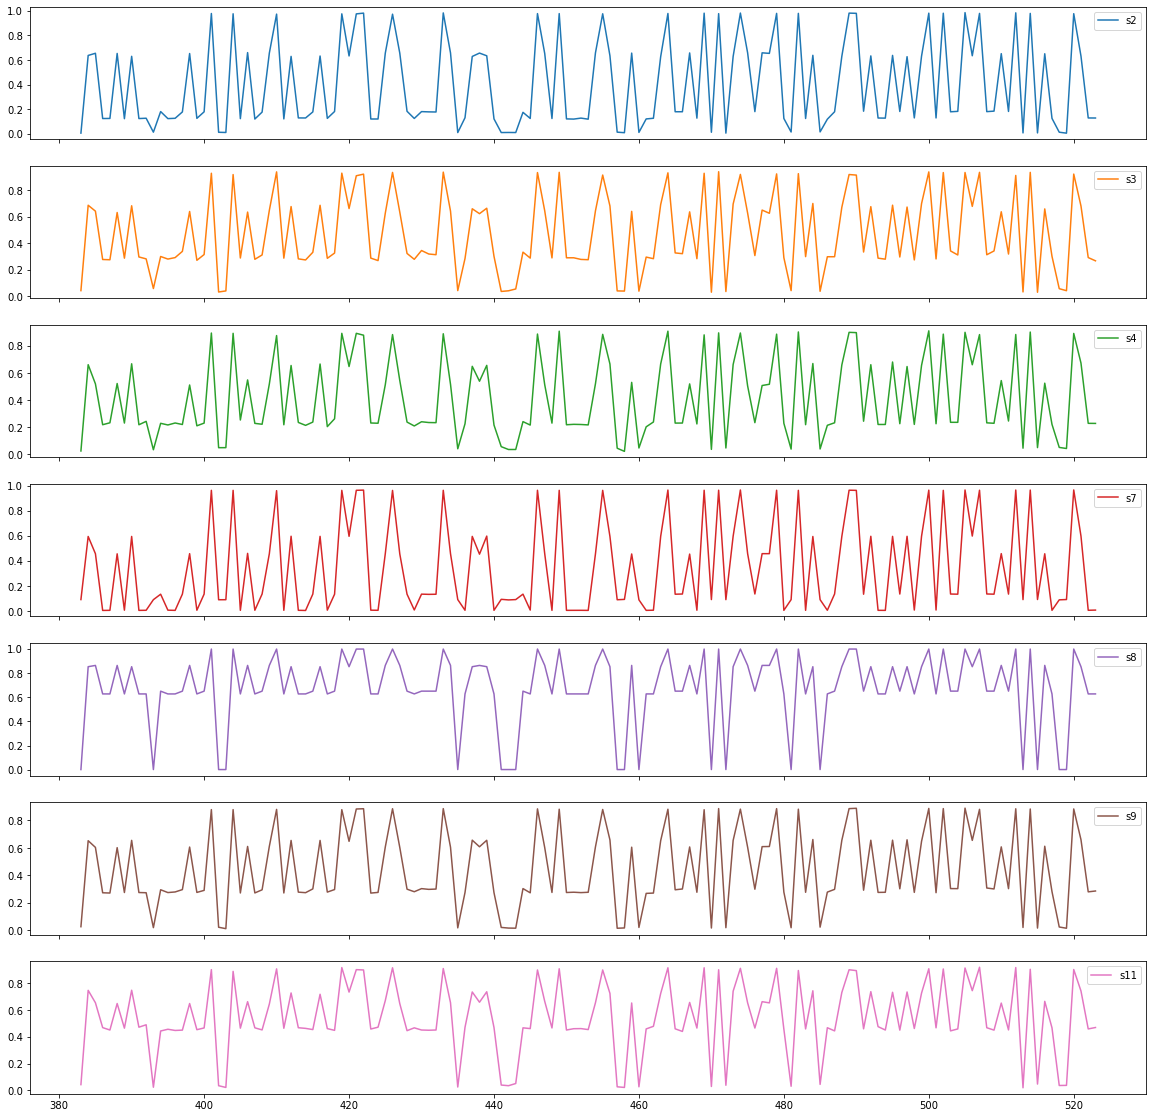

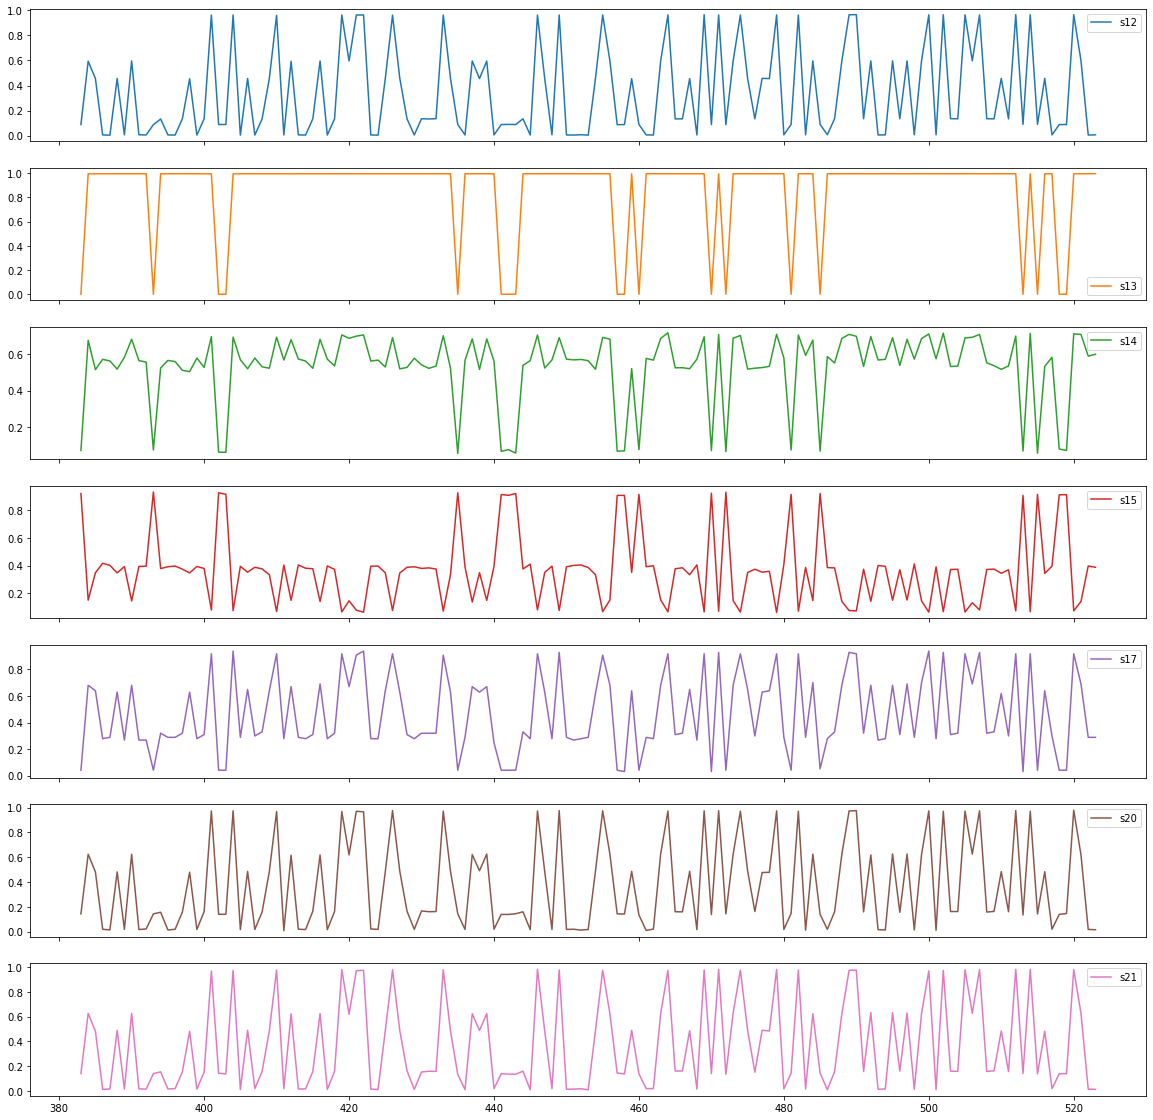

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\alibei\AppData\Local\Temp/ipykernel_5396/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

249
249
249
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\alibei\AppData\Local\Temp/ipykernel_5396/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

151
151
151
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 1 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Number of iteration: 1 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [115.07]
Epoch 0 	Batch: 50 - 75 	Loss: [115.1]
Epoch 1 	Batch: 50 - 75 	Loss: [115.08]
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 0 	Batch: 50 - 75 	Loss: [115.1]
Epoch 1 	Batch: 50 - 75 	Loss: [115.08]
Epoch 0 	Batch: 50 - 75 	Loss: [115.08]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Epoch 0 	Batch: 50 - 75 	Loss: [115.1]
Epoch 1 	Batch: 50 - 75 	Loss: [115.08]
Epoch 0 	Batch: 50 - 75 	Loss: [115.12]
Epoch 1 	Batch: 50 - 75 	Loss: [115.1]
Epoch 0 	Batch: 50 - 75 	Loss: [115.09]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Epoch 0 	Batch: 50 - 75 	Loss: [115.11]
Epoch 1 	Batch: 50 - 75 	Loss: [115.09]
Epoch 0 	Batch: 50 - 75 	Loss: [115.08]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Number of iteration: 11 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.05]
Epoch 1 	Batch: 50 - 75 	Loss: [115.03]
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 0 	Batch: 50 - 75 	Loss: [115.01]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [114.53]
Epoch 0 	Batch: 50 - 75 	Loss: [114.58]
Epoch 1 	Batch: 50 - 75 	Loss: [114.55]
Epoch 0 	Batch: 50 - 75 	Loss: [114.43]
Epoch 1 	Batch: 50 - 75 	Loss: [114.39]
Epoch 0 	Batch: 50 - 75 	Loss: [114.57]
Epoch 1 	Batch: 50 - 75 	Loss: [114.54]
Epoch 0 	Batch: 50 - 75 	Loss: [114.51]
Epoch 1 	Batch: 50 - 75 	Loss: [114.48]
Epoch 0 	Batch: 50 - 75 	Loss: [114.57]
Epoch 1 	Batch: 50 - 75 	Loss: [114.54]
Epoch 0 	Batch: 50 - 75 	Loss: [114.71]
Epoch 1 	Batch: 50 - 75 	Loss: [114.69]
Epoch 0 	Batch: 50 - 75 	Loss: [114.55]
Epoch 1 	Batch: 50 - 75 	Loss: [114.53]
Epoch 0 	Batch: 50 - 75 	Loss: [114.54]
Epoch 1 	Batch: 50 - 75 	Loss: [114.51]
Epoch 0 	Batch: 50 - 75 	Loss: [114.52]
Epoch 1 	Batch: 50 - 75 	Loss: [114.49]
Number of iteration: 21 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.5]
Epoch 1 	Batch: 50 - 75 	Loss: [114.47]
Epoch 0 	Batch: 50 - 75 	Loss: [114.52]
Epoch 1 	Batch: 50 - 75 	Loss: [114.49]
Epoch 0 	Batch: 50 - 75 	Loss: [114.35]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [113.67]
Epoch 0 	Batch: 50 - 75 	Loss: [113.37]
Epoch 1 	Batch: 50 - 75 	Loss: [113.32]
Epoch 0 	Batch: 50 - 75 	Loss: [113.71]
Epoch 1 	Batch: 50 - 75 	Loss: [113.68]
Epoch 0 	Batch: 50 - 75 	Loss: [113.55]
Epoch 1 	Batch: 50 - 75 	Loss: [113.5]
Epoch 0 	Batch: 50 - 75 	Loss: [113.65]
Epoch 1 	Batch: 50 - 75 	Loss: [113.61]
Epoch 0 	Batch: 50 - 75 	Loss: [114.1]
Epoch 1 	Batch: 50 - 75 	Loss: [114.08]
Epoch 0 	Batch: 50 - 75 	Loss: [113.69]
Epoch 1 	Batch: 50 - 75 	Loss: [113.64]
Epoch 0 	Batch: 50 - 75 	Loss: [113.54]
Epoch 1 	Batch: 50 - 75 	Loss: [113.47]
Epoch 0 	Batch: 50 - 75 	Loss: [113.57]
Epoch 1 	Batch: 50 - 75 	Loss: [113.5]
Number of iteration: 31 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.6]
Epoch 1 	Batch: 50 - 75 	Loss: [113.55]
Epoch 0 	Batch: 50 - 75 	Loss: [113.61]
Epoch 1 	Batch: 50 - 75 	Loss: [113.57]
Epoch 0 	Batch: 50 - 75 	Loss: [113.26]
Epoch 1 	Batch: 50 - 75 	Loss: [113.21]
Epoch 0 	Batch: 50 - 75 	Loss: [113.63]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [112.37]
Epoch 0 	Batch: 50 - 75 	Loss: [111.84]
Epoch 1 	Batch: 50 - 75 	Loss: [111.76]
Epoch 0 	Batch: 50 - 75 	Loss: [112.27]
Epoch 1 	Batch: 50 - 75 	Loss: [112.18]
Epoch 0 	Batch: 50 - 75 	Loss: [112.]
Epoch 1 	Batch: 50 - 75 	Loss: [111.91]
Epoch 0 	Batch: 50 - 75 	Loss: [112.27]
Epoch 1 	Batch: 50 - 75 	Loss: [112.19]
Epoch 0 	Batch: 50 - 75 	Loss: [113.11]
Epoch 1 	Batch: 50 - 75 	Loss: [113.05]
Epoch 0 	Batch: 50 - 75 	Loss: [112.37]
Epoch 1 	Batch: 50 - 75 	Loss: [112.31]
Epoch 0 	Batch: 50 - 75 	Loss: [112.01]
Epoch 1 	Batch: 50 - 75 	Loss: [111.92]
Epoch 0 	Batch: 50 - 75 	Loss: [112.16]
Epoch 1 	Batch: 50 - 75 	Loss: [112.08]
Number of iteration: 41 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [112.13]
Epoch 1 	Batch: 50 - 75 	Loss: [112.08]
Epoch 0 	Batch: 50 - 75 	Loss: [112.31]
Epoch 1 	Batch: 50 - 75 	Loss: [112.23]
Epoch 0 	Batch: 50 - 75 	Loss: [111.68]
Epoch 1 	Batch: 50 - 75 	Loss: [111.61]
Epoch 0 	Batch: 50 - 75 	Loss: [112.1]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [110.66]
Epoch 0 	Batch: 50 - 75 	Loss: [110.13]
Epoch 1 	Batch: 50 - 75 	Loss: [110.01]
Epoch 0 	Batch: 50 - 75 	Loss: [110.74]
Epoch 1 	Batch: 50 - 75 	Loss: [110.66]
Epoch 0 	Batch: 50 - 75 	Loss: [110.08]
Epoch 1 	Batch: 50 - 75 	Loss: [109.99]
Epoch 0 	Batch: 50 - 75 	Loss: [110.47]
Epoch 1 	Batch: 50 - 75 	Loss: [110.37]
Epoch 0 	Batch: 50 - 75 	Loss: [111.97]
Epoch 1 	Batch: 50 - 75 	Loss: [111.91]
Epoch 0 	Batch: 50 - 75 	Loss: [110.72]
Epoch 1 	Batch: 50 - 75 	Loss: [110.63]
Epoch 0 	Batch: 50 - 75 	Loss: [110.15]
Epoch 1 	Batch: 50 - 75 	Loss: [110.05]
Epoch 0 	Batch: 50 - 75 	Loss: [110.33]
Epoch 1 	Batch: 50 - 75 	Loss: [110.24]
Number of iteration: 51 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [110.55]
Epoch 1 	Batch: 50 - 75 	Loss: [110.45]
Epoch 0 	Batch: 50 - 75 	Loss: [110.56]
Epoch 1 	Batch: 50 - 75 	Loss: [110.45]
Epoch 0 	Batch: 50 - 75 	Loss: [109.91]
Epoch 1 	Batch: 50 - 75 	Loss: [109.82]
Epoch 0 	Batch: 50 - 75 	Loss: [110.56]
Epoch

Epoch 1 	Batch: 50 - 75 	Loss: [108.79]
Epoch 0 	Batch: 50 - 75 	Loss: [109.05]
Epoch 1 	Batch: 50 - 75 	Loss: [108.96]
Epoch 0 	Batch: 50 - 75 	Loss: [108.2]
Epoch 1 	Batch: 50 - 75 	Loss: [108.09]
Epoch 0 	Batch: 50 - 75 	Loss: [109.11]
Epoch 1 	Batch: 50 - 75 	Loss: [109.02]
Epoch 0 	Batch: 50 - 75 	Loss: [108.17]
Epoch 1 	Batch: 50 - 75 	Loss: [108.09]
Epoch 0 	Batch: 50 - 75 	Loss: [108.81]
Epoch 1 	Batch: 50 - 75 	Loss: [108.73]
Epoch 0 	Batch: 50 - 75 	Loss: [110.76]
Epoch 1 	Batch: 50 - 75 	Loss: [110.7]
Epoch 0 	Batch: 50 - 75 	Loss: [108.97]
Epoch 1 	Batch: 50 - 75 	Loss: [108.89]
Epoch 0 	Batch: 50 - 75 	Loss: [108.22]
Epoch 1 	Batch: 50 - 75 	Loss: [108.13]
Epoch 0 	Batch: 50 - 75 	Loss: [108.35]
Epoch 1 	Batch: 50 - 75 	Loss: [108.26]
Number of iteration: 61 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [108.71]
Epoch 1 	Batch: 50 - 75 	Loss: [108.62]
Epoch 0 	Batch: 50 - 75 	Loss: [108.87]
Epoch 1 	Batch: 50 - 75 	Loss: [108.77]
Epoch 0 	Batch: 50 - 75 	Loss: [107.99]
Epoch 1

Epoch 0 	Batch: 50 - 75 	Loss: [107.06]
Epoch 1 	Batch: 50 - 75 	Loss: [106.95]
Epoch 0 	Batch: 50 - 75 	Loss: [105.8]
Epoch 1 	Batch: 50 - 75 	Loss: [105.69]
Epoch 0 	Batch: 50 - 75 	Loss: [107.07]
Epoch 1 	Batch: 50 - 75 	Loss: [106.97]
Epoch 0 	Batch: 50 - 75 	Loss: [105.97]
Epoch 1 	Batch: 50 - 75 	Loss: [105.85]
Epoch 0 	Batch: 50 - 75 	Loss: [106.7]
Epoch 1 	Batch: 50 - 75 	Loss: [106.59]
Epoch 0 	Batch: 50 - 75 	Loss: [109.19]
Epoch 1 	Batch: 50 - 75 	Loss: [109.11]
Epoch 0 	Batch: 50 - 75 	Loss: [106.93]
Epoch 1 	Batch: 50 - 75 	Loss: [106.83]
Epoch 0 	Batch: 50 - 75 	Loss: [105.93]
Epoch 1 	Batch: 50 - 75 	Loss: [105.8]
Epoch 0 	Batch: 50 - 75 	Loss: [106.09]
Epoch 1 	Batch: 50 - 75 	Loss: [105.97]
Number of iteration: 71 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [106.5]
Epoch 1 	Batch: 50 - 75 	Loss: [106.41]
Epoch 0 	Batch: 50 - 75 	Loss: [106.84]
Epoch 1 	Batch: 50 - 75 	Loss: [106.75]
Epoch 0 	Batch: 50 - 75 	Loss: [105.56]
Epoch 1 	Batch: 50 - 75 	Loss: [105.47]
Epoch 0 	

Number of iteration: 80 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.43]
Epoch 1 	Batch: 50 - 75 	Loss: [104.32]
Epoch 0 	Batch: 50 - 75 	Loss: [104.92]
Epoch 1 	Batch: 50 - 75 	Loss: [104.8]
Epoch 0 	Batch: 50 - 75 	Loss: [103.37]
Epoch 1 	Batch: 50 - 75 	Loss: [103.25]
Epoch 0 	Batch: 50 - 75 	Loss: [105.01]
Epoch 1 	Batch: 50 - 75 	Loss: [104.92]
Epoch 0 	Batch: 50 - 75 	Loss: [103.71]
Epoch 1 	Batch: 50 - 75 	Loss: [103.61]
Epoch 0 	Batch: 50 - 75 	Loss: [104.39]
Epoch 1 	Batch: 50 - 75 	Loss: [104.27]
Epoch 0 	Batch: 50 - 75 	Loss: [107.63]
Epoch 1 	Batch: 50 - 75 	Loss: [107.58]
Epoch 0 	Batch: 50 - 75 	Loss: [104.91]
Epoch 1 	Batch: 50 - 75 	Loss: [104.82]
Epoch 0 	Batch: 50 - 75 	Loss: [103.4]
Epoch 1 	Batch: 50 - 75 	Loss: [103.27]
Epoch 0 	Batch: 50 - 75 	Loss: [103.7]
Epoch 1 	Batch: 50 - 75 	Loss: [103.59]
Number of iteration: 81 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.2]
Epoch 1 	Batch: 50 - 75 	Loss: [104.09]
Epoch 0 	Batch: 50 - 75 	Loss: [104.69]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [101.2]
Epoch 1 	Batch: 50 - 75 	Loss: [101.07]
Epoch 0 	Batch: 50 - 75 	Loss: [101.54]
Epoch 1 	Batch: 50 - 75 	Loss: [101.42]
Number of iteration: 90 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [102.16]
Epoch 1 	Batch: 50 - 75 	Loss: [102.03]
Epoch 0 	Batch: 50 - 75 	Loss: [102.77]
Epoch 1 	Batch: 50 - 75 	Loss: [102.66]
Epoch 0 	Batch: 50 - 75 	Loss: [100.98]
Epoch 1 	Batch: 50 - 75 	Loss: [100.85]
Epoch 0 	Batch: 50 - 75 	Loss: [103.]
Epoch 1 	Batch: 50 - 75 	Loss: [102.9]
Epoch 0 	Batch: 50 - 75 	Loss: [101.43]
Epoch 1 	Batch: 50 - 75 	Loss: [101.32]
Epoch 0 	Batch: 50 - 75 	Loss: [102.07]
Epoch 1 	Batch: 50 - 75 	Loss: [101.94]
Epoch 0 	Batch: 50 - 75 	Loss: [106.27]
Epoch 1 	Batch: 50 - 75 	Loss: [106.24]
Epoch 0 	Batch: 50 - 75 	Loss: [102.9]
Epoch 1 	Batch: 50 - 75 	Loss: [102.8]
Epoch 0 	Batch: 50 - 75 	Loss: [100.96]
Epoch 1 	Batch: 50 - 75 	Loss: [100.82]
Epoch 0 	Batch: 50 - 75 	Loss: [101.32]
Epoch 1 	Batch: 50 - 75 	Loss: [101.19]
Number of i

Epoch 1 	Batch: 50 - 75 	Loss: [98.51]
Epoch 0 	Batch: 50 - 75 	Loss: [99.08]
Epoch 1 	Batch: 50 - 75 	Loss: [98.95]
Number of iteration: 100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [99.83]
Epoch 1 	Batch: 50 - 75 	Loss: [99.7]
Epoch 0 	Batch: 50 - 75 	Loss: [100.66]
Epoch 1 	Batch: 50 - 75 	Loss: [100.54]
Epoch 0 	Batch: 50 - 75 	Loss: [98.58]
Epoch 1 	Batch: 50 - 75 	Loss: [98.44]
Epoch 0 	Batch: 50 - 75 	Loss: [100.96]
Epoch 1 	Batch: 50 - 75 	Loss: [100.85]
Epoch 0 	Batch: 50 - 75 	Loss: [99.11]
Epoch 1 	Batch: 50 - 75 	Loss: [98.99]
Epoch 0 	Batch: 50 - 75 	Loss: [99.79]
Epoch 1 	Batch: 50 - 75 	Loss: [99.65]
Epoch 0 	Batch: 50 - 75 	Loss: [104.82]
Epoch 1 	Batch: 50 - 75 	Loss: [104.78]
Epoch 0 	Batch: 50 - 75 	Loss: [100.85]
Epoch 1 	Batch: 50 - 75 	Loss: [100.75]
Epoch 0 	Batch: 50 - 75 	Loss: [98.41]
Epoch 1 	Batch: 50 - 75 	Loss: [98.27]
Epoch 0 	Batch: 50 - 75 	Loss: [98.83]
Epoch 1 	Batch: 50 - 75 	Loss: [98.68]
Number of iteration: 101 /from 3000
Epoch 0 	Batch: 50 - 75 

Epoch 1 	Batch: 50 - 75 	Loss: [96.3]
Number of iteration: 110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [97.27]
Epoch 1 	Batch: 50 - 75 	Loss: [97.13]
Epoch 0 	Batch: 50 - 75 	Loss: [98.36]
Epoch 1 	Batch: 50 - 75 	Loss: [98.24]
Epoch 0 	Batch: 50 - 75 	Loss: [96.01]
Epoch 1 	Batch: 50 - 75 	Loss: [95.87]
Epoch 0 	Batch: 50 - 75 	Loss: [98.72]
Epoch 1 	Batch: 50 - 75 	Loss: [98.61]
Epoch 0 	Batch: 50 - 75 	Loss: [96.65]
Epoch 1 	Batch: 50 - 75 	Loss: [96.54]
Epoch 0 	Batch: 50 - 75 	Loss: [97.33]
Epoch 1 	Batch: 50 - 75 	Loss: [97.19]
Epoch 0 	Batch: 50 - 75 	Loss: [103.23]
Epoch 1 	Batch: 50 - 75 	Loss: [103.23]
Epoch 0 	Batch: 50 - 75 	Loss: [98.64]
Epoch 1 	Batch: 50 - 75 	Loss: [98.54]
Epoch 0 	Batch: 50 - 75 	Loss: [95.68]
Epoch 1 	Batch: 50 - 75 	Loss: [95.53]
Epoch 0 	Batch: 50 - 75 	Loss: [96.17]
Epoch 1 	Batch: 50 - 75 	Loss: [96.02]
Number of iteration: 111 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [97.]
Epoch 1 	Batch: 50 - 75 	Loss: [96.88]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [96.]
Epoch 1 	Batch: 50 - 75 	Loss: [95.87]
Epoch 0 	Batch: 50 - 75 	Loss: [93.3]
Epoch 1 	Batch: 50 - 75 	Loss: [93.16]
Epoch 0 	Batch: 50 - 75 	Loss: [96.37]
Epoch 1 	Batch: 50 - 75 	Loss: [96.25]
Epoch 0 	Batch: 50 - 75 	Loss: [94.13]
Epoch 1 	Batch: 50 - 75 	Loss: [94.01]
Epoch 0 	Batch: 50 - 75 	Loss: [94.79]
Epoch 1 	Batch: 50 - 75 	Loss: [94.65]
Epoch 0 	Batch: 50 - 75 	Loss: [101.62]
Epoch 1 	Batch: 50 - 75 	Loss: [101.59]
Epoch 0 	Batch: 50 - 75 	Loss: [96.35]
Epoch 1 	Batch: 50 - 75 	Loss: [96.24]
Epoch 0 	Batch: 50 - 75 	Loss: [92.89]
Epoch 1 	Batch: 50 - 75 	Loss: [92.74]
Epoch 0 	Batch: 50 - 75 	Loss: [93.4]
Epoch 1 	Batch: 50 - 75 	Loss: [93.26]
Number of iteration: 121 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [94.35]
Epoch 1 	Batch: 50 - 75 	Loss: [94.23]
Epoch 0 	Batch: 50 - 75 	Loss: [95.75]
Epoch 1 	Batch: 50 - 75 	Loss: [95.63]
Epoch 0 	Batch: 50 - 75 	Loss: [93.02]
Epoch 1 	Batch: 50 - 75 	Loss: [92.89]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [90.59]
Epoch 1 	Batch: 50 - 75 	Loss: [90.45]
Epoch 0 	Batch: 50 - 75 	Loss: [93.99]
Epoch 1 	Batch: 50 - 75 	Loss: [93.88]
Epoch 0 	Batch: 50 - 75 	Loss: [91.66]
Epoch 1 	Batch: 50 - 75 	Loss: [91.54]
Epoch 0 	Batch: 50 - 75 	Loss: [92.24]
Epoch 1 	Batch: 50 - 75 	Loss: [92.1]
Epoch 0 	Batch: 50 - 75 	Loss: [99.94]
Epoch 1 	Batch: 50 - 75 	Loss: [99.93]
Epoch 0 	Batch: 50 - 75 	Loss: [94.05]
Epoch 1 	Batch: 50 - 75 	Loss: [93.94]
Epoch 0 	Batch: 50 - 75 	Loss: [90.07]
Epoch 1 	Batch: 50 - 75 	Loss: [89.92]
Epoch 0 	Batch: 50 - 75 	Loss: [90.6]
Epoch 1 	Batch: 50 - 75 	Loss: [90.45]
Number of iteration: 131 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [91.69]
Epoch 1 	Batch: 50 - 75 	Loss: [91.56]
Epoch 0 	Batch: 50 - 75 	Loss: [93.38]
Epoch 1 	Batch: 50 - 75 	Loss: [93.25]
Epoch 0 	Batch: 50 - 75 	Loss: [90.31]
Epoch 1 	Batch: 50 - 75 	Loss: [90.17]
Epoch 0 	Batch: 50 - 75 	Loss: [93.75]
Epoch 1 	Batch: 50 - 75 	Loss: [93.63]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [91.61]
Epoch 1 	Batch: 50 - 75 	Loss: [91.49]
Epoch 0 	Batch: 50 - 75 	Loss: [89.22]
Epoch 1 	Batch: 50 - 75 	Loss: [89.1]
Epoch 0 	Batch: 50 - 75 	Loss: [89.71]
Epoch 1 	Batch: 50 - 75 	Loss: [89.56]
Epoch 0 	Batch: 50 - 75 	Loss: [98.25]
Epoch 1 	Batch: 50 - 75 	Loss: [98.22]
Epoch 0 	Batch: 50 - 75 	Loss: [91.75]
Epoch 1 	Batch: 50 - 75 	Loss: [91.64]
Epoch 0 	Batch: 50 - 75 	Loss: [87.26]
Epoch 1 	Batch: 50 - 75 	Loss: [87.11]
Epoch 0 	Batch: 50 - 75 	Loss: [87.82]
Epoch 1 	Batch: 50 - 75 	Loss: [87.67]
Number of iteration: 141 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [89.03]
Epoch 1 	Batch: 50 - 75 	Loss: [88.9]
Epoch 0 	Batch: 50 - 75 	Loss: [91.]
Epoch 1 	Batch: 50 - 75 	Loss: [90.88]
Epoch 0 	Batch: 50 - 75 	Loss: [87.57]
Epoch 1 	Batch: 50 - 75 	Loss: [87.43]
Epoch 0 	Batch: 50 - 75 	Loss: [91.36]
Epoch 1 	Batch: 50 - 75 	Loss: [91.24]
Epoch 0 	Batch: 50 - 75 	Loss: [88.96]
Epoch 1 	Batch: 50 - 75 	Loss: [88.83]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [86.57]
Epoch 0 	Batch: 50 - 75 	Loss: [87.11]
Epoch 1 	Batch: 50 - 75 	Loss: [86.97]
Epoch 0 	Batch: 50 - 75 	Loss: [96.44]
Epoch 1 	Batch: 50 - 75 	Loss: [96.32]
Epoch 0 	Batch: 50 - 75 	Loss: [89.4]
Epoch 1 	Batch: 50 - 75 	Loss: [89.29]
Epoch 0 	Batch: 50 - 75 	Loss: [84.34]
Epoch 1 	Batch: 50 - 75 	Loss: [84.19]
Epoch 0 	Batch: 50 - 75 	Loss: [84.99]
Epoch 1 	Batch: 50 - 75 	Loss: [84.84]
Number of iteration: 151 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [86.33]
Epoch 1 	Batch: 50 - 75 	Loss: [86.18]
Epoch 0 	Batch: 50 - 75 	Loss: [88.59]
Epoch 1 	Batch: 50 - 75 	Loss: [88.47]
Epoch 0 	Batch: 50 - 75 	Loss: [84.77]
Epoch 1 	Batch: 50 - 75 	Loss: [84.62]
Epoch 0 	Batch: 50 - 75 	Loss: [88.89]
Epoch 1 	Batch: 50 - 75 	Loss: [88.76]
Epoch 0 	Batch: 50 - 75 	Loss: [86.44]
Epoch 1 	Batch: 50 - 75 	Loss: [86.3]
Epoch 0 	Batch: 50 - 75 	Loss: [86.85]
Epoch 1 	Batch: 50 - 75 	Loss: [86.71]
Epoch 0 	Batch: 50 - 75 	Loss: [96.21]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [87.02]
Epoch 1 	Batch: 50 - 75 	Loss: [86.91]
Epoch 0 	Batch: 50 - 75 	Loss: [81.38]
Epoch 1 	Batch: 50 - 75 	Loss: [81.23]
Epoch 0 	Batch: 50 - 75 	Loss: [82.12]
Epoch 1 	Batch: 50 - 75 	Loss: [81.97]
Number of iteration: 161 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [83.59]
Epoch 1 	Batch: 50 - 75 	Loss: [83.45]
Epoch 0 	Batch: 50 - 75 	Loss: [86.15]
Epoch 1 	Batch: 50 - 75 	Loss: [86.03]
Epoch 0 	Batch: 50 - 75 	Loss: [81.89]
Epoch 1 	Batch: 50 - 75 	Loss: [81.74]
Epoch 0 	Batch: 50 - 75 	Loss: [86.35]
Epoch 1 	Batch: 50 - 75 	Loss: [86.23]
Epoch 0 	Batch: 50 - 75 	Loss: [83.91]
Epoch 1 	Batch: 50 - 75 	Loss: [83.79]
Epoch 0 	Batch: 50 - 75 	Loss: [84.21]
Epoch 1 	Batch: 50 - 75 	Loss: [84.07]
Epoch 0 	Batch: 50 - 75 	Loss: [94.08]
Epoch 1 	Batch: 50 - 75 	Loss: [93.99]
Epoch 0 	Batch: 50 - 75 	Loss: [86.79]
Epoch 1 	Batch: 50 - 75 	Loss: [86.68]
Epoch 0 	Batch: 50 - 75 	Loss: [81.08]
Epoch 1 	Batch: 50 - 75 	Loss: [80.93]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [79.11]
Number of iteration: 171 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [80.91]
Epoch 1 	Batch: 50 - 75 	Loss: [80.77]
Epoch 0 	Batch: 50 - 75 	Loss: [83.75]
Epoch 1 	Batch: 50 - 75 	Loss: [83.63]
Epoch 0 	Batch: 50 - 75 	Loss: [79.01]
Epoch 1 	Batch: 50 - 75 	Loss: [78.87]
Epoch 0 	Batch: 50 - 75 	Loss: [83.84]
Epoch 1 	Batch: 50 - 75 	Loss: [83.7]
Epoch 0 	Batch: 50 - 75 	Loss: [81.43]
Epoch 1 	Batch: 50 - 75 	Loss: [81.29]
Epoch 0 	Batch: 50 - 75 	Loss: [81.57]
Epoch 1 	Batch: 50 - 75 	Loss: [81.44]
Epoch 0 	Batch: 50 - 75 	Loss: [92.02]
Epoch 1 	Batch: 50 - 75 	Loss: [91.9]
Epoch 0 	Batch: 50 - 75 	Loss: [84.47]
Epoch 1 	Batch: 50 - 75 	Loss: [84.35]
Epoch 0 	Batch: 50 - 75 	Loss: [78.15]
Epoch 1 	Batch: 50 - 75 	Loss: [78.]
Epoch 0 	Batch: 50 - 75 	Loss: [78.97]
Epoch 1 	Batch: 50 - 75 	Loss: [78.83]
Number of iteration: 172 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [80.65]
Epoch 1 	Batch: 50 - 75 	Loss: [80.51]
Epoch 0 	Batch: 50 - 75 	Loss: [83.

Epoch 0 	Batch: 50 - 75 	Loss: [78.19]
Epoch 1 	Batch: 50 - 75 	Loss: [78.04]
Epoch 0 	Batch: 50 - 75 	Loss: [81.35]
Epoch 1 	Batch: 50 - 75 	Loss: [81.23]
Epoch 0 	Batch: 50 - 75 	Loss: [76.14]
Epoch 1 	Batch: 50 - 75 	Loss: [76.]
Epoch 0 	Batch: 50 - 75 	Loss: [81.32]
Epoch 1 	Batch: 50 - 75 	Loss: [81.19]
Epoch 0 	Batch: 50 - 75 	Loss: [78.99]
Epoch 1 	Batch: 50 - 75 	Loss: [78.87]
Epoch 0 	Batch: 50 - 75 	Loss: [78.96]
Epoch 1 	Batch: 50 - 75 	Loss: [78.82]
Epoch 0 	Batch: 50 - 75 	Loss: [89.91]
Epoch 1 	Batch: 50 - 75 	Loss: [89.8]
Epoch 0 	Batch: 50 - 75 	Loss: [82.21]
Epoch 1 	Batch: 50 - 75 	Loss: [82.1]
Epoch 0 	Batch: 50 - 75 	Loss: [75.23]
Epoch 1 	Batch: 50 - 75 	Loss: [75.09]
Epoch 0 	Batch: 50 - 75 	Loss: [76.14]
Epoch 1 	Batch: 50 - 75 	Loss: [75.99]
Number of iteration: 182 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [77.9]
Epoch 1 	Batch: 50 - 75 	Loss: [77.76]
Epoch 0 	Batch: 50 - 75 	Loss: [81.11]
Epoch 1 	Batch: 50 - 75 	Loss: [80.99]
Epoch 0 	Batch: 50 - 75 	Loss: [7

Epoch 0 	Batch: 50 - 75 	Loss: [73.29]
Epoch 1 	Batch: 50 - 75 	Loss: [73.15]
Epoch 0 	Batch: 50 - 75 	Loss: [78.78]
Epoch 1 	Batch: 50 - 75 	Loss: [78.67]
Epoch 0 	Batch: 50 - 75 	Loss: [76.58]
Epoch 1 	Batch: 50 - 75 	Loss: [76.46]
Epoch 0 	Batch: 50 - 75 	Loss: [76.35]
Epoch 1 	Batch: 50 - 75 	Loss: [76.21]
Epoch 0 	Batch: 50 - 75 	Loss: [87.75]
Epoch 1 	Batch: 50 - 75 	Loss: [87.68]
Epoch 0 	Batch: 50 - 75 	Loss: [79.99]
Epoch 1 	Batch: 50 - 75 	Loss: [79.88]
Epoch 0 	Batch: 50 - 75 	Loss: [72.32]
Epoch 1 	Batch: 50 - 75 	Loss: [72.17]
Epoch 0 	Batch: 50 - 75 	Loss: [73.31]
Epoch 1 	Batch: 50 - 75 	Loss: [73.16]
Number of iteration: 192 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [75.13]
Epoch 1 	Batch: 50 - 75 	Loss: [74.98]
Epoch 0 	Batch: 50 - 75 	Loss: [78.72]
Epoch 1 	Batch: 50 - 75 	Loss: [78.59]
Epoch 0 	Batch: 50 - 75 	Loss: [73.01]
Epoch 1 	Batch: 50 - 75 	Loss: [72.87]
Epoch 0 	Batch: 50 - 75 	Loss: [78.55]
Epoch 1 	Batch: 50 - 75 	Loss: [78.42]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [76.12]
Epoch 0 	Batch: 50 - 75 	Loss: [74.08]
Epoch 1 	Batch: 50 - 75 	Loss: [73.95]
Epoch 0 	Batch: 50 - 75 	Loss: [73.68]
Epoch 1 	Batch: 50 - 75 	Loss: [73.55]
Epoch 0 	Batch: 50 - 75 	Loss: [85.54]
Epoch 1 	Batch: 50 - 75 	Loss: [85.42]
Epoch 0 	Batch: 50 - 75 	Loss: [77.65]
Epoch 1 	Batch: 50 - 75 	Loss: [77.54]
Epoch 0 	Batch: 50 - 75 	Loss: [69.42]
Epoch 1 	Batch: 50 - 75 	Loss: [69.27]
Epoch 0 	Batch: 50 - 75 	Loss: [70.49]
Epoch 1 	Batch: 50 - 75 	Loss: [70.35]
Number of iteration: 202 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.3]
Epoch 1 	Batch: 50 - 75 	Loss: [72.16]
Epoch 0 	Batch: 50 - 75 	Loss: [76.3]
Epoch 1 	Batch: 50 - 75 	Loss: [76.18]
Epoch 0 	Batch: 50 - 75 	Loss: [70.27]
Epoch 1 	Batch: 50 - 75 	Loss: [70.13]
Epoch 0 	Batch: 50 - 75 	Loss: [75.99]
Epoch 1 	Batch: 50 - 75 	Loss: [75.86]
Epoch 0 	Batch: 50 - 75 	Loss: [73.83]
Epoch 1 	Batch: 50 - 75 	Loss: [73.71]
Epoch 0 	Batch: 50 - 75 	Loss: [73.42]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [71.68]
Epoch 1 	Batch: 50 - 75 	Loss: [71.56]
Epoch 0 	Batch: 50 - 75 	Loss: [71.05]
Epoch 1 	Batch: 50 - 75 	Loss: [70.91]
Epoch 0 	Batch: 50 - 75 	Loss: [83.28]
Epoch 1 	Batch: 50 - 75 	Loss: [83.16]
Epoch 0 	Batch: 50 - 75 	Loss: [75.37]
Epoch 1 	Batch: 50 - 75 	Loss: [75.26]
Epoch 0 	Batch: 50 - 75 	Loss: [66.56]
Epoch 1 	Batch: 50 - 75 	Loss: [66.42]
Epoch 0 	Batch: 50 - 75 	Loss: [67.74]
Epoch 1 	Batch: 50 - 75 	Loss: [67.62]
Number of iteration: 212 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [69.53]
Epoch 1 	Batch: 50 - 75 	Loss: [69.4]
Epoch 0 	Batch: 50 - 75 	Loss: [73.92]
Epoch 1 	Batch: 50 - 75 	Loss: [73.79]
Epoch 0 	Batch: 50 - 75 	Loss: [67.51]
Epoch 1 	Batch: 50 - 75 	Loss: [67.38]
Epoch 0 	Batch: 50 - 75 	Loss: [73.65]
Epoch 1 	Batch: 50 - 75 	Loss: [73.52]
Epoch 0 	Batch: 50 - 75 	Loss: [71.44]
Epoch 1 	Batch: 50 - 75 	Loss: [71.33]
Epoch 0 	Batch: 50 - 75 	Loss: [70.78]
Epoch 1 	Batch: 50 - 75 	Loss: [70.65]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [80.98]
Epoch 1 	Batch: 50 - 75 	Loss: [80.87]
Epoch 0 	Batch: 50 - 75 	Loss: [73.13]
Epoch 1 	Batch: 50 - 75 	Loss: [73.04]
Epoch 0 	Batch: 50 - 75 	Loss: [63.76]
Epoch 1 	Batch: 50 - 75 	Loss: [63.62]
Epoch 0 	Batch: 50 - 75 	Loss: [65.09]
Epoch 1 	Batch: 50 - 75 	Loss: [64.95]
Number of iteration: 222 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [66.9]
Epoch 1 	Batch: 50 - 75 	Loss: [66.77]
Epoch 0 	Batch: 50 - 75 	Loss: [71.54]
Epoch 1 	Batch: 50 - 75 	Loss: [71.42]
Epoch 0 	Batch: 50 - 75 	Loss: [64.86]
Epoch 1 	Batch: 50 - 75 	Loss: [64.75]
Epoch 0 	Batch: 50 - 75 	Loss: [71.19]
Epoch 1 	Batch: 50 - 75 	Loss: [71.07]
Epoch 0 	Batch: 50 - 75 	Loss: [69.01]
Epoch 1 	Batch: 50 - 75 	Loss: [68.9]
Epoch 0 	Batch: 50 - 75 	Loss: [68.18]
Epoch 1 	Batch: 50 - 75 	Loss: [68.05]
Epoch 0 	Batch: 50 - 75 	Loss: [80.76]
Epoch 1 	Batch: 50 - 75 	Loss: [80.64]
Epoch 0 	Batch: 50 - 75 	Loss: [72.92]
Epoch 1 	Batch: 50 - 75 	Loss: [72.83]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [60.95]
Epoch 0 	Batch: 50 - 75 	Loss: [62.57]
Epoch 1 	Batch: 50 - 75 	Loss: [62.43]
Number of iteration: 232 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.28]
Epoch 1 	Batch: 50 - 75 	Loss: [64.15]
Epoch 0 	Batch: 50 - 75 	Loss: [69.26]
Epoch 1 	Batch: 50 - 75 	Loss: [69.15]
Epoch 0 	Batch: 50 - 75 	Loss: [62.57]
Epoch 1 	Batch: 50 - 75 	Loss: [62.46]
Epoch 0 	Batch: 50 - 75 	Loss: [68.94]
Epoch 1 	Batch: 50 - 75 	Loss: [68.82]
Epoch 0 	Batch: 50 - 75 	Loss: [66.69]
Epoch 1 	Batch: 50 - 75 	Loss: [66.57]
Epoch 0 	Batch: 50 - 75 	Loss: [65.67]
Epoch 1 	Batch: 50 - 75 	Loss: [65.54]
Epoch 0 	Batch: 50 - 75 	Loss: [78.66]
Epoch 1 	Batch: 50 - 75 	Loss: [78.55]
Epoch 0 	Batch: 50 - 75 	Loss: [70.71]
Epoch 1 	Batch: 50 - 75 	Loss: [70.6]
Epoch 0 	Batch: 50 - 75 	Loss: [60.82]
Epoch 1 	Batch: 50 - 75 	Loss: [60.68]
Epoch 0 	Batch: 50 - 75 	Loss: [62.3]
Epoch 1 	Batch: 50 - 75 	Loss: [62.16]
Number of iteration: 233 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6

Epoch 0 	Batch: 50 - 75 	Loss: [67.01]
Epoch 1 	Batch: 50 - 75 	Loss: [66.89]
Epoch 0 	Batch: 50 - 75 	Loss: [59.99]
Epoch 1 	Batch: 50 - 75 	Loss: [59.86]
Epoch 0 	Batch: 50 - 75 	Loss: [66.64]
Epoch 1 	Batch: 50 - 75 	Loss: [66.53]
Epoch 0 	Batch: 50 - 75 	Loss: [64.36]
Epoch 1 	Batch: 50 - 75 	Loss: [64.25]
Epoch 0 	Batch: 50 - 75 	Loss: [63.19]
Epoch 1 	Batch: 50 - 75 	Loss: [63.06]
Epoch 0 	Batch: 50 - 75 	Loss: [76.46]
Epoch 1 	Batch: 50 - 75 	Loss: [76.36]
Epoch 0 	Batch: 50 - 75 	Loss: [68.48]
Epoch 1 	Batch: 50 - 75 	Loss: [68.37]
Epoch 0 	Batch: 50 - 75 	Loss: [58.16]
Epoch 1 	Batch: 50 - 75 	Loss: [58.03]
Epoch 0 	Batch: 50 - 75 	Loss: [59.65]
Epoch 1 	Batch: 50 - 75 	Loss: [59.52]
Number of iteration: 243 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.41]
Epoch 1 	Batch: 50 - 75 	Loss: [61.27]
Epoch 0 	Batch: 50 - 75 	Loss: [66.78]
Epoch 1 	Batch: 50 - 75 	Loss: [66.66]
Epoch 0 	Batch: 50 - 75 	Loss: [59.73]
Epoch 1 	Batch: 50 - 75 	Loss: [59.6]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [64.47]
Epoch 1 	Batch: 50 - 75 	Loss: [64.37]
Epoch 0 	Batch: 50 - 75 	Loss: [62.07]
Epoch 1 	Batch: 50 - 75 	Loss: [61.95]
Epoch 0 	Batch: 50 - 75 	Loss: [60.73]
Epoch 1 	Batch: 50 - 75 	Loss: [60.6]
Epoch 0 	Batch: 50 - 75 	Loss: [74.34]
Epoch 1 	Batch: 50 - 75 	Loss: [74.24]
Epoch 0 	Batch: 50 - 75 	Loss: [66.28]
Epoch 1 	Batch: 50 - 75 	Loss: [66.17]
Epoch 0 	Batch: 50 - 75 	Loss: [55.58]
Epoch 1 	Batch: 50 - 75 	Loss: [55.45]
Epoch 0 	Batch: 50 - 75 	Loss: [57.14]
Epoch 1 	Batch: 50 - 75 	Loss: [57.02]
Number of iteration: 253 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.84]
Epoch 1 	Batch: 50 - 75 	Loss: [58.73]
Epoch 0 	Batch: 50 - 75 	Loss: [64.54]
Epoch 1 	Batch: 50 - 75 	Loss: [64.42]
Epoch 0 	Batch: 50 - 75 	Loss: [57.17]
Epoch 1 	Batch: 50 - 75 	Loss: [57.04]
Epoch 0 	Batch: 50 - 75 	Loss: [64.27]
Epoch 1 	Batch: 50 - 75 	Loss: [64.18]
Epoch 0 	Batch: 50 - 75 	Loss: [61.84]
Epoch 1 	Batch: 50 - 75 	Loss: [61.74]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [59.75]
Epoch 0 	Batch: 50 - 75 	Loss: [58.32]
Epoch 1 	Batch: 50 - 75 	Loss: [58.19]
Epoch 0 	Batch: 50 - 75 	Loss: [72.2]
Epoch 1 	Batch: 50 - 75 	Loss: [72.08]
Epoch 0 	Batch: 50 - 75 	Loss: [64.18]
Epoch 1 	Batch: 50 - 75 	Loss: [64.09]
Epoch 0 	Batch: 50 - 75 	Loss: [53.07]
Epoch 1 	Batch: 50 - 75 	Loss: [52.95]
Epoch 0 	Batch: 50 - 75 	Loss: [54.64]
Epoch 1 	Batch: 50 - 75 	Loss: [54.51]
Number of iteration: 263 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.44]
Epoch 1 	Batch: 50 - 75 	Loss: [56.32]
Epoch 0 	Batch: 50 - 75 	Loss: [62.38]
Epoch 1 	Batch: 50 - 75 	Loss: [62.28]
Epoch 0 	Batch: 50 - 75 	Loss: [54.7]
Epoch 1 	Batch: 50 - 75 	Loss: [54.58]
Epoch 0 	Batch: 50 - 75 	Loss: [62.1]
Epoch 1 	Batch: 50 - 75 	Loss: [62.]
Epoch 0 	Batch: 50 - 75 	Loss: [59.64]
Epoch 1 	Batch: 50 - 75 	Loss: [59.53]
Epoch 0 	Batch: 50 - 75 	Loss: [58.08]
Epoch 1 	Batch: 50 - 75 	Loss: [57.96]
Epoch 0 	Batch: 50 - 75 	Loss: [71.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7

Epoch 0 	Batch: 50 - 75 	Loss: [70.03]
Epoch 1 	Batch: 50 - 75 	Loss: [69.94]
Epoch 0 	Batch: 50 - 75 	Loss: [62.15]
Epoch 1 	Batch: 50 - 75 	Loss: [62.05]
Epoch 0 	Batch: 50 - 75 	Loss: [50.63]
Epoch 1 	Batch: 50 - 75 	Loss: [50.51]
Epoch 0 	Batch: 50 - 75 	Loss: [52.19]
Epoch 1 	Batch: 50 - 75 	Loss: [52.07]
Number of iteration: 273 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 1 	Batch: 50 - 75 	Loss: [53.94]
Epoch 0 	Batch: 50 - 75 	Loss: [60.27]
Epoch 1 	Batch: 50 - 75 	Loss: [60.16]
Epoch 0 	Batch: 50 - 75 	Loss: [52.32]
Epoch 1 	Batch: 50 - 75 	Loss: [52.2]
Epoch 0 	Batch: 50 - 75 	Loss: [59.96]
Epoch 1 	Batch: 50 - 75 	Loss: [59.86]
Epoch 0 	Batch: 50 - 75 	Loss: [57.47]
Epoch 1 	Batch: 50 - 75 	Loss: [57.37]
Epoch 0 	Batch: 50 - 75 	Loss: [55.72]
Epoch 1 	Batch: 50 - 75 	Loss: [55.6]
Epoch 0 	Batch: 50 - 75 	Loss: [69.84]
Epoch 1 	Batch: 50 - 75 	Loss: [69.73]
Epoch 0 	Batch: 50 - 75 	Loss: [61.95]
Epoch 1 	Batch: 50 - 75 	Loss: [61.84]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [48.28]
Epoch 1 	Batch: 50 - 75 	Loss: [48.16]
Epoch 0 	Batch: 50 - 75 	Loss: [49.84]
Epoch 1 	Batch: 50 - 75 	Loss: [49.73]
Number of iteration: 283 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.83]
Epoch 1 	Batch: 50 - 75 	Loss: [51.72]
Epoch 0 	Batch: 50 - 75 	Loss: [58.2]
Epoch 1 	Batch: 50 - 75 	Loss: [58.09]
Epoch 0 	Batch: 50 - 75 	Loss: [50.]
Epoch 1 	Batch: 50 - 75 	Loss: [49.89]
Epoch 0 	Batch: 50 - 75 	Loss: [57.74]
Epoch 1 	Batch: 50 - 75 	Loss: [57.63]
Epoch 0 	Batch: 50 - 75 	Loss: [55.36]
Epoch 1 	Batch: 50 - 75 	Loss: [55.26]
Epoch 0 	Batch: 50 - 75 	Loss: [53.44]
Epoch 1 	Batch: 50 - 75 	Loss: [53.32]
Epoch 0 	Batch: 50 - 75 	Loss: [67.72]
Epoch 1 	Batch: 50 - 75 	Loss: [67.63]
Epoch 0 	Batch: 50 - 75 	Loss: [59.99]
Epoch 1 	Batch: 50 - 75 	Loss: [59.9]
Epoch 0 	Batch: 50 - 75 	Loss: [48.05]
Epoch 1 	Batch: 50 - 75 	Loss: [47.93]
Epoch 0 	Batch: 50 - 75 	Loss: [49.62]
Epoch 1 	Batch: 50 - 75 	Loss: [49.51]
Number of iteration: 284 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [47.6]
Epoch 1 	Batch: 50 - 75 	Loss: [47.49]
Number of iteration: 293 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.65]
Epoch 1 	Batch: 50 - 75 	Loss: [49.54]
Epoch 0 	Batch: 50 - 75 	Loss: [56.19]
Epoch 1 	Batch: 50 - 75 	Loss: [56.09]
Epoch 0 	Batch: 50 - 75 	Loss: [47.77]
Epoch 1 	Batch: 50 - 75 	Loss: [47.66]
Epoch 0 	Batch: 50 - 75 	Loss: [55.53]
Epoch 1 	Batch: 50 - 75 	Loss: [55.41]
Epoch 0 	Batch: 50 - 75 	Loss: [53.3]
Epoch 1 	Batch: 50 - 75 	Loss: [53.21]
Epoch 0 	Batch: 50 - 75 	Loss: [51.24]
Epoch 1 	Batch: 50 - 75 	Loss: [51.13]
Epoch 0 	Batch: 50 - 75 	Loss: [65.63]
Epoch 1 	Batch: 50 - 75 	Loss: [65.52]
Epoch 0 	Batch: 50 - 75 	Loss: [57.92]
Epoch 1 	Batch: 50 - 75 	Loss: [57.82]
Epoch 0 	Batch: 50 - 75 	Loss: [45.79]
Epoch 1 	Batch: 50 - 75 	Loss: [45.68]
Epoch 0 	Batch: 50 - 75 	Loss: [47.38]
Epoch 1 	Batch: 50 - 75 	Loss: [47.27]
Number of iteration: 294 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.43]
Epoch 1 	Batch: 50 - 75 	Loss: [4

Epoch 1 	Batch: 50 - 75 	Loss: [47.5]
Epoch 0 	Batch: 50 - 75 	Loss: [54.23]
Epoch 1 	Batch: 50 - 75 	Loss: [54.13]
Epoch 0 	Batch: 50 - 75 	Loss: [45.69]
Epoch 1 	Batch: 50 - 75 	Loss: [45.59]
Epoch 0 	Batch: 50 - 75 	Loss: [53.41]
Epoch 1 	Batch: 50 - 75 	Loss: [53.31]
Epoch 0 	Batch: 50 - 75 	Loss: [51.31]
Epoch 1 	Batch: 50 - 75 	Loss: [51.22]
Epoch 0 	Batch: 50 - 75 	Loss: [49.16]
Epoch 1 	Batch: 50 - 75 	Loss: [49.05]
Epoch 0 	Batch: 50 - 75 	Loss: [63.57]
Epoch 1 	Batch: 50 - 75 	Loss: [63.48]
Epoch 0 	Batch: 50 - 75 	Loss: [55.89]
Epoch 1 	Batch: 50 - 75 	Loss: [55.8]
Epoch 0 	Batch: 50 - 75 	Loss: [43.64]
Epoch 1 	Batch: 50 - 75 	Loss: [43.53]
Epoch 0 	Batch: 50 - 75 	Loss: [45.58]
Epoch 1 	Batch: 50 - 75 	Loss: [45.47]
Number of iteration: 304 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.39]
Epoch 1 	Batch: 50 - 75 	Loss: [47.28]
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 1 	Batch: 50 - 75 	Loss: [53.94]
Epoch 0 	Batch: 50 - 75 	Loss: [45.48]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [43.51]
Epoch 0 	Batch: 50 - 75 	Loss: [51.45]
Epoch 1 	Batch: 50 - 75 	Loss: [51.35]
Epoch 0 	Batch: 50 - 75 	Loss: [49.37]
Epoch 1 	Batch: 50 - 75 	Loss: [49.28]
Epoch 0 	Batch: 50 - 75 	Loss: [47.07]
Epoch 1 	Batch: 50 - 75 	Loss: [46.96]
Epoch 0 	Batch: 50 - 75 	Loss: [61.6]
Epoch 1 	Batch: 50 - 75 	Loss: [61.51]
Epoch 0 	Batch: 50 - 75 	Loss: [53.97]
Epoch 1 	Batch: 50 - 75 	Loss: [53.87]
Epoch 0 	Batch: 50 - 75 	Loss: [41.58]
Epoch 1 	Batch: 50 - 75 	Loss: [41.48]
Epoch 0 	Batch: 50 - 75 	Loss: [43.45]
Epoch 1 	Batch: 50 - 75 	Loss: [43.35]
Number of iteration: 314 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.31]
Epoch 1 	Batch: 50 - 75 	Loss: [45.22]
Epoch 0 	Batch: 50 - 75 	Loss: [52.14]
Epoch 1 	Batch: 50 - 75 	Loss: [52.04]
Epoch 0 	Batch: 50 - 75 	Loss: [43.42]
Epoch 1 	Batch: 50 - 75 	Loss: [43.32]
Epoch 0 	Batch: 50 - 75 	Loss: [51.25]
Epoch 1 	Batch: 50 - 75 	Loss: [51.15]
Epoch 0 	Batch: 50 - 75 	Loss: [49.18]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [44.94]
Epoch 0 	Batch: 50 - 75 	Loss: [59.61]
Epoch 1 	Batch: 50 - 75 	Loss: [59.55]
Epoch 0 	Batch: 50 - 75 	Loss: [52.09]
Epoch 1 	Batch: 50 - 75 	Loss: [52.]
Epoch 0 	Batch: 50 - 75 	Loss: [39.6]
Epoch 1 	Batch: 50 - 75 	Loss: [39.5]
Epoch 0 	Batch: 50 - 75 	Loss: [41.5]
Epoch 1 	Batch: 50 - 75 	Loss: [41.39]
Number of iteration: 324 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.31]
Epoch 1 	Batch: 50 - 75 	Loss: [43.23]
Epoch 0 	Batch: 50 - 75 	Loss: [50.25]
Epoch 1 	Batch: 50 - 75 	Loss: [50.15]
Epoch 0 	Batch: 50 - 75 	Loss: [41.46]
Epoch 1 	Batch: 50 - 75 	Loss: [41.36]
Epoch 0 	Batch: 50 - 75 	Loss: [49.35]
Epoch 1 	Batch: 50 - 75 	Loss: [49.28]
Epoch 0 	Batch: 50 - 75 	Loss: [47.25]
Epoch 1 	Batch: 50 - 75 	Loss: [47.15]
Epoch 0 	Batch: 50 - 75 	Loss: [44.85]
Epoch 1 	Batch: 50 - 75 	Loss: [44.74]
Epoch 0 	Batch: 50 - 75 	Loss: [59.45]
Epoch 1 	Batch: 50 - 75 	Loss: [59.36]
Epoch 0 	Batch: 50 - 75 	Loss: [51.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [50.24]
Epoch 1 	Batch: 50 - 75 	Loss: [50.16]
Epoch 0 	Batch: 50 - 75 	Loss: [37.7]
Epoch 1 	Batch: 50 - 75 	Loss: [37.6]
Epoch 0 	Batch: 50 - 75 	Loss: [39.58]
Epoch 1 	Batch: 50 - 75 	Loss: [39.48]
Number of iteration: 334 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.49]
Epoch 1 	Batch: 50 - 75 	Loss: [41.38]
Epoch 0 	Batch: 50 - 75 	Loss: [48.46]
Epoch 1 	Batch: 50 - 75 	Loss: [48.36]
Epoch 0 	Batch: 50 - 75 	Loss: [39.59]
Epoch 1 	Batch: 50 - 75 	Loss: [39.49]
Epoch 0 	Batch: 50 - 75 	Loss: [47.56]
Epoch 1 	Batch: 50 - 75 	Loss: [47.47]
Epoch 0 	Batch: 50 - 75 	Loss: [45.44]
Epoch 1 	Batch: 50 - 75 	Loss: [45.35]
Epoch 0 	Batch: 50 - 75 	Loss: [42.89]
Epoch 1 	Batch: 50 - 75 	Loss: [42.79]
Epoch 0 	Batch: 50 - 75 	Loss: [57.64]
Epoch 1 	Batch: 50 - 75 	Loss: [57.54]
Epoch 0 	Batch: 50 - 75 	Loss: [50.06]
Epoch 1 	Batch: 50 - 75 	Loss: [49.97]
Epoch 0 	Batch: 50 - 75 	Loss: [37.51]
Epoch 1 	Batch: 50 - 75 	Loss: [37.41]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [35.86]
Epoch 1 	Batch: 50 - 75 	Loss: [35.77]
Epoch 0 	Batch: 50 - 75 	Loss: [37.66]
Epoch 1 	Batch: 50 - 75 	Loss: [37.57]
Number of iteration: 344 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.51]
Epoch 1 	Batch: 50 - 75 	Loss: [39.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.64]
Epoch 1 	Batch: 50 - 75 	Loss: [46.55]
Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 1 	Batch: 50 - 75 	Loss: [37.63]
Epoch 0 	Batch: 50 - 75 	Loss: [45.65]
Epoch 1 	Batch: 50 - 75 	Loss: [45.55]
Epoch 0 	Batch: 50 - 75 	Loss: [43.58]
Epoch 1 	Batch: 50 - 75 	Loss: [43.49]
Epoch 0 	Batch: 50 - 75 	Loss: [41.03]
Epoch 1 	Batch: 50 - 75 	Loss: [40.94]
Epoch 0 	Batch: 50 - 75 	Loss: [55.73]
Epoch 1 	Batch: 50 - 75 	Loss: [55.65]
Epoch 0 	Batch: 50 - 75 	Loss: [48.2]
Epoch 1 	Batch: 50 - 75 	Loss: [48.11]
Epoch 0 	Batch: 50 - 75 	Loss: [35.68]
Epoch 1 	Batch: 50 - 75 	Loss: [35.59]
Epoch 0 	Batch: 50 - 75 	Loss: [37.47]
Epoch 1 	Batch: 50 - 75 	Loss: [37.38]
Number of iteration: 345 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [37.87]
Epoch 1 	Batch: 50 - 75 	Loss: [37.8]
Epoch 0 	Batch: 50 - 75 	Loss: [44.86]
Epoch 1 	Batch: 50 - 75 	Loss: [44.76]
Epoch 0 	Batch: 50 - 75 	Loss: [35.94]
Epoch 1 	Batch: 50 - 75 	Loss: [35.85]
Epoch 0 	Batch: 50 - 75 	Loss: [43.79]
Epoch 1 	Batch: 50 - 75 	Loss: [43.69]
Epoch 0 	Batch: 50 - 75 	Loss: [41.77]
Epoch 1 	Batch: 50 - 75 	Loss: [41.69]
Epoch 0 	Batch: 50 - 75 	Loss: [39.2]
Epoch 1 	Batch: 50 - 75 	Loss: [39.11]
Epoch 0 	Batch: 50 - 75 	Loss: [53.86]
Epoch 1 	Batch: 50 - 75 	Loss: [53.77]
Epoch 0 	Batch: 50 - 75 	Loss: [46.39]
Epoch 1 	Batch: 50 - 75 	Loss: [46.3]
Epoch 0 	Batch: 50 - 75 	Loss: [33.93]
Epoch 1 	Batch: 50 - 75 	Loss: [33.85]
Epoch 0 	Batch: 50 - 75 	Loss: [35.63]
Epoch 1 	Batch: 50 - 75 	Loss: [35.54]
Number of iteration: 355 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.73]
Epoch 1 	Batch: 50 - 75 	Loss: [37.64]
Epoch 0 	Batch: 50 - 75 	Loss: [44.68]
Epoch 1 	Batch: 50 - 75 	Loss: [44.59]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [42.15]
Epoch 1 	Batch: 50 - 75 	Loss: [42.06]
Epoch 0 	Batch: 50 - 75 	Loss: [40.03]
Epoch 1 	Batch: 50 - 75 	Loss: [39.94]
Epoch 0 	Batch: 50 - 75 	Loss: [37.43]
Epoch 1 	Batch: 50 - 75 	Loss: [37.34]
Epoch 0 	Batch: 50 - 75 	Loss: [52.07]
Epoch 1 	Batch: 50 - 75 	Loss: [51.98]
Epoch 0 	Batch: 50 - 75 	Loss: [44.88]
Epoch 1 	Batch: 50 - 75 	Loss: [44.79]
Epoch 0 	Batch: 50 - 75 	Loss: [32.26]
Epoch 1 	Batch: 50 - 75 	Loss: [32.17]
Epoch 0 	Batch: 50 - 75 	Loss: [33.85]
Epoch 1 	Batch: 50 - 75 	Loss: [33.76]
Number of iteration: 365 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.95]
Epoch 1 	Batch: 50 - 75 	Loss: [35.86]
Epoch 0 	Batch: 50 - 75 	Loss: [42.94]
Epoch 1 	Batch: 50 - 75 	Loss: [42.85]
Epoch 0 	Batch: 50 - 75 	Loss: [34.05]
Epoch 1 	Batch: 50 - 75 	Loss: [33.97]
Epoch 0 	Batch: 50 - 75 	Loss: [41.98]
Epoch 1 	Batch: 50 - 75 	Loss: [41.89]
Epoch 0 	Batch: 50 - 75 	Loss: [39.86]
Epoch 1 	Batch: 50 - 75 	Loss: [39.79]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [35.72]
Epoch 1 	Batch: 50 - 75 	Loss: [35.65]
Epoch 0 	Batch: 50 - 75 	Loss: [50.37]
Epoch 1 	Batch: 50 - 75 	Loss: [50.28]
Epoch 0 	Batch: 50 - 75 	Loss: [43.15]
Epoch 1 	Batch: 50 - 75 	Loss: [43.06]
Epoch 0 	Batch: 50 - 75 	Loss: [30.64]
Epoch 1 	Batch: 50 - 75 	Loss: [30.57]
Epoch 0 	Batch: 50 - 75 	Loss: [32.16]
Epoch 1 	Batch: 50 - 75 	Loss: [32.07]
Number of iteration: 375 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.19]
Epoch 1 	Batch: 50 - 75 	Loss: [34.11]
Epoch 0 	Batch: 50 - 75 	Loss: [41.34]
Epoch 1 	Batch: 50 - 75 	Loss: [41.26]
Epoch 0 	Batch: 50 - 75 	Loss: [32.4]
Epoch 1 	Batch: 50 - 75 	Loss: [32.32]
Epoch 0 	Batch: 50 - 75 	Loss: [40.24]
Epoch 1 	Batch: 50 - 75 	Loss: [40.16]
Epoch 0 	Batch: 50 - 75 	Loss: [38.15]
Epoch 1 	Batch: 50 - 75 	Loss: [38.07]
Epoch 0 	Batch: 50 - 75 	Loss: [35.57]
Epoch 1 	Batch: 50 - 75 	Loss: [35.49]
Epoch 0 	Batch: 50 - 75 	Loss: [50.2]
Epoch 1 	Batch: 50 - 75 	Loss: [50.11]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [48.69]
Epoch 1 	Batch: 50 - 75 	Loss: [48.6]
Epoch 0 	Batch: 50 - 75 	Loss: [41.47]
Epoch 1 	Batch: 50 - 75 	Loss: [41.39]
Epoch 0 	Batch: 50 - 75 	Loss: [29.11]
Epoch 1 	Batch: 50 - 75 	Loss: [29.03]
Epoch 0 	Batch: 50 - 75 	Loss: [30.55]
Epoch 1 	Batch: 50 - 75 	Loss: [30.47]
Number of iteration: 385 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.92]
Epoch 1 	Batch: 50 - 75 	Loss: [32.85]
Epoch 0 	Batch: 50 - 75 	Loss: [39.93]
Epoch 1 	Batch: 50 - 75 	Loss: [39.84]
Epoch 0 	Batch: 50 - 75 	Loss: [30.88]
Epoch 1 	Batch: 50 - 75 	Loss: [30.81]
Epoch 0 	Batch: 50 - 75 	Loss: [38.66]
Epoch 1 	Batch: 50 - 75 	Loss: [38.6]
Epoch 0 	Batch: 50 - 75 	Loss: [36.52]
Epoch 1 	Batch: 50 - 75 	Loss: [36.44]
Epoch 0 	Batch: 50 - 75 	Loss: [34.06]
Epoch 1 	Batch: 50 - 75 	Loss: [34.01]
Epoch 0 	Batch: 50 - 75 	Loss: [48.52]
Epoch 1 	Batch: 50 - 75 	Loss: [48.43]
Epoch 0 	Batch: 50 - 75 	Loss: [41.31]
Epoch 1 	Batch: 50 - 75 	Loss: [41.22]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [27.58]
Epoch 0 	Batch: 50 - 75 	Loss: [29.56]
Epoch 1 	Batch: 50 - 75 	Loss: [29.49]
Number of iteration: 395 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.43]
Epoch 1 	Batch: 50 - 75 	Loss: [31.34]
Epoch 0 	Batch: 50 - 75 	Loss: [38.35]
Epoch 1 	Batch: 50 - 75 	Loss: [38.29]
Epoch 0 	Batch: 50 - 75 	Loss: [29.43]
Epoch 1 	Batch: 50 - 75 	Loss: [29.36]
Epoch 0 	Batch: 50 - 75 	Loss: [37.26]
Epoch 1 	Batch: 50 - 75 	Loss: [37.2]
Epoch 0 	Batch: 50 - 75 	Loss: [35.06]
Epoch 1 	Batch: 50 - 75 	Loss: [35.]
Epoch 0 	Batch: 50 - 75 	Loss: [32.58]
Epoch 1 	Batch: 50 - 75 	Loss: [32.5]
Epoch 0 	Batch: 50 - 75 	Loss: [46.86]
Epoch 1 	Batch: 50 - 75 	Loss: [46.79]
Epoch 0 	Batch: 50 - 75 	Loss: [39.75]
Epoch 1 	Batch: 50 - 75 	Loss: [39.68]
Epoch 0 	Batch: 50 - 75 	Loss: [27.51]
Epoch 1 	Batch: 50 - 75 	Loss: [27.44]
Epoch 0 	Batch: 50 - 75 	Loss: [29.41]
Epoch 1 	Batch: 50 - 75 	Loss: [29.33]
Number of iteration: 396 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.

Epoch 0 	Batch: 50 - 75 	Loss: [37.22]
Epoch 1 	Batch: 50 - 75 	Loss: [37.14]
Epoch 0 	Batch: 50 - 75 	Loss: [28.03]
Epoch 1 	Batch: 50 - 75 	Loss: [27.97]
Epoch 0 	Batch: 50 - 75 	Loss: [35.79]
Epoch 1 	Batch: 50 - 75 	Loss: [35.72]
Epoch 0 	Batch: 50 - 75 	Loss: [33.58]
Epoch 1 	Batch: 50 - 75 	Loss: [33.5]
Epoch 0 	Batch: 50 - 75 	Loss: [31.11]
Epoch 1 	Batch: 50 - 75 	Loss: [31.04]
Epoch 0 	Batch: 50 - 75 	Loss: [45.28]
Epoch 1 	Batch: 50 - 75 	Loss: [45.2]
Epoch 0 	Batch: 50 - 75 	Loss: [38.24]
Epoch 1 	Batch: 50 - 75 	Loss: [38.16]
Epoch 0 	Batch: 50 - 75 	Loss: [26.13]
Epoch 1 	Batch: 50 - 75 	Loss: [26.07]
Epoch 0 	Batch: 50 - 75 	Loss: [27.93]
Epoch 1 	Batch: 50 - 75 	Loss: [27.86]
Number of iteration: 406 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.84]
Epoch 1 	Batch: 50 - 75 	Loss: [29.76]
Epoch 0 	Batch: 50 - 75 	Loss: [37.07]
Epoch 1 	Batch: 50 - 75 	Loss: [36.99]
Epoch 0 	Batch: 50 - 75 	Loss: [27.89]
Epoch 1 	Batch: 50 - 75 	Loss: [27.83]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [26.64]
Epoch 1 	Batch: 50 - 75 	Loss: [26.58]
Epoch 0 	Batch: 50 - 75 	Loss: [34.41]
Epoch 1 	Batch: 50 - 75 	Loss: [34.34]
Epoch 0 	Batch: 50 - 75 	Loss: [32.09]
Epoch 1 	Batch: 50 - 75 	Loss: [32.01]
Epoch 0 	Batch: 50 - 75 	Loss: [29.7]
Epoch 1 	Batch: 50 - 75 	Loss: [29.63]
Epoch 0 	Batch: 50 - 75 	Loss: [43.61]
Epoch 1 	Batch: 50 - 75 	Loss: [43.53]
Epoch 0 	Batch: 50 - 75 	Loss: [36.73]
Epoch 1 	Batch: 50 - 75 	Loss: [36.65]
Epoch 0 	Batch: 50 - 75 	Loss: [24.79]
Epoch 1 	Batch: 50 - 75 	Loss: [24.72]
Epoch 0 	Batch: 50 - 75 	Loss: [26.47]
Epoch 1 	Batch: 50 - 75 	Loss: [26.4]
Number of iteration: 416 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.33]
Epoch 1 	Batch: 50 - 75 	Loss: [28.25]
Epoch 0 	Batch: 50 - 75 	Loss: [35.51]
Epoch 1 	Batch: 50 - 75 	Loss: [35.43]
Epoch 0 	Batch: 50 - 75 	Loss: [26.51]
Epoch 1 	Batch: 50 - 75 	Loss: [26.44]
Epoch 0 	Batch: 50 - 75 	Loss: [34.27]
Epoch 1 	Batch: 50 - 75 	Loss: [34.19]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [32.97]
Epoch 1 	Batch: 50 - 75 	Loss: [32.9]
Epoch 0 	Batch: 50 - 75 	Loss: [30.55]
Epoch 1 	Batch: 50 - 75 	Loss: [30.48]
Epoch 0 	Batch: 50 - 75 	Loss: [28.38]
Epoch 1 	Batch: 50 - 75 	Loss: [28.31]
Epoch 0 	Batch: 50 - 75 	Loss: [41.97]
Epoch 1 	Batch: 50 - 75 	Loss: [41.89]
Epoch 0 	Batch: 50 - 75 	Loss: [35.22]
Epoch 1 	Batch: 50 - 75 	Loss: [35.15]
Epoch 0 	Batch: 50 - 75 	Loss: [23.5]
Epoch 1 	Batch: 50 - 75 	Loss: [23.43]
Epoch 0 	Batch: 50 - 75 	Loss: [25.07]
Epoch 1 	Batch: 50 - 75 	Loss: [25.]
Number of iteration: 426 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.88]
Epoch 1 	Batch: 50 - 75 	Loss: [26.81]
Epoch 0 	Batch: 50 - 75 	Loss: [34.]
Epoch 1 	Batch: 50 - 75 	Loss: [33.92]
Epoch 0 	Batch: 50 - 75 	Loss: [25.17]
Epoch 1 	Batch: 50 - 75 	Loss: [25.11]
Epoch 0 	Batch: 50 - 75 	Loss: [32.83]
Epoch 1 	Batch: 50 - 75 	Loss: [32.76]
Epoch 0 	Batch: 50 - 75 	Loss: [30.4]
Epoch 1 	Batch: 50 - 75 	Loss: [30.33]
Epoch 0 	Batch: 50 - 75 	Loss: [28.

Epoch 1 	Batch: 50 - 75 	Loss: [26.96]
Epoch 0 	Batch: 50 - 75 	Loss: [40.45]
Epoch 1 	Batch: 50 - 75 	Loss: [40.4]
Epoch 0 	Batch: 50 - 75 	Loss: [33.76]
Epoch 1 	Batch: 50 - 75 	Loss: [33.69]
Epoch 0 	Batch: 50 - 75 	Loss: [22.29]
Epoch 1 	Batch: 50 - 75 	Loss: [22.23]
Epoch 0 	Batch: 50 - 75 	Loss: [23.76]
Epoch 1 	Batch: 50 - 75 	Loss: [23.7]
Number of iteration: 436 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.76]
Epoch 1 	Batch: 50 - 75 	Loss: [25.71]
Epoch 0 	Batch: 50 - 75 	Loss: [32.55]
Epoch 1 	Batch: 50 - 75 	Loss: [32.47]
Epoch 0 	Batch: 50 - 75 	Loss: [23.91]
Epoch 1 	Batch: 50 - 75 	Loss: [23.84]
Epoch 0 	Batch: 50 - 75 	Loss: [31.43]
Epoch 1 	Batch: 50 - 75 	Loss: [31.36]
Epoch 0 	Batch: 50 - 75 	Loss: [28.95]
Epoch 1 	Batch: 50 - 75 	Loss: [28.88]
Epoch 0 	Batch: 50 - 75 	Loss: [26.89]
Epoch 1 	Batch: 50 - 75 	Loss: [26.82]
Epoch 0 	Batch: 50 - 75 	Loss: [40.33]
Epoch 1 	Batch: 50 - 75 	Loss: [40.25]
Epoch 0 	Batch: 50 - 75 	Loss: [33.62]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [32.36]
Epoch 1 	Batch: 50 - 75 	Loss: [32.29]
Epoch 0 	Batch: 50 - 75 	Loss: [21.14]
Epoch 1 	Batch: 50 - 75 	Loss: [21.08]
Epoch 0 	Batch: 50 - 75 	Loss: [22.52]
Epoch 1 	Batch: 50 - 75 	Loss: [22.46]
Number of iteration: 446 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.72]
Epoch 1 	Batch: 50 - 75 	Loss: [24.65]
Epoch 0 	Batch: 50 - 75 	Loss: [31.17]
Epoch 1 	Batch: 50 - 75 	Loss: [31.1]
Epoch 0 	Batch: 50 - 75 	Loss: [22.72]
Epoch 1 	Batch: 50 - 75 	Loss: [22.66]
Epoch 0 	Batch: 50 - 75 	Loss: [30.03]
Epoch 1 	Batch: 50 - 75 	Loss: [29.95]
Epoch 0 	Batch: 50 - 75 	Loss: [27.54]
Epoch 1 	Batch: 50 - 75 	Loss: [27.48]
Epoch 0 	Batch: 50 - 75 	Loss: [25.6]
Epoch 1 	Batch: 50 - 75 	Loss: [25.54]
Epoch 0 	Batch: 50 - 75 	Loss: [38.88]
Epoch 1 	Batch: 50 - 75 	Loss: [38.79]
Epoch 0 	Batch: 50 - 75 	Loss: [32.22]
Epoch 1 	Batch: 50 - 75 	Loss: [32.15]
Epoch 0 	Batch: 50 - 75 	Loss: [21.02]
Epoch 1 	Batch: 50 - 75 	Loss: [20.96]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [21.28]
Number of iteration: 456 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.41]
Epoch 1 	Batch: 50 - 75 	Loss: [23.34]
Epoch 0 	Batch: 50 - 75 	Loss: [29.81]
Epoch 1 	Batch: 50 - 75 	Loss: [29.74]
Epoch 0 	Batch: 50 - 75 	Loss: [21.56]
Epoch 1 	Batch: 50 - 75 	Loss: [21.51]
Epoch 0 	Batch: 50 - 75 	Loss: [28.64]
Epoch 1 	Batch: 50 - 75 	Loss: [28.57]
Epoch 0 	Batch: 50 - 75 	Loss: [26.19]
Epoch 1 	Batch: 50 - 75 	Loss: [26.13]
Epoch 0 	Batch: 50 - 75 	Loss: [24.38]
Epoch 1 	Batch: 50 - 75 	Loss: [24.32]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Epoch 1 	Batch: 50 - 75 	Loss: [37.28]
Epoch 0 	Batch: 50 - 75 	Loss: [30.86]
Epoch 1 	Batch: 50 - 75 	Loss: [30.79]
Epoch 0 	Batch: 50 - 75 	Loss: [19.93]
Epoch 1 	Batch: 50 - 75 	Loss: [19.88]
Epoch 0 	Batch: 50 - 75 	Loss: [21.22]
Epoch 1 	Batch: 50 - 75 	Loss: [21.16]
Number of iteration: 457 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.28]
Epoch 1 	Batch: 50 - 75 	Loss: [23.21]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [20.44]
Epoch 1 	Batch: 50 - 75 	Loss: [20.39]
Epoch 0 	Batch: 50 - 75 	Loss: [27.32]
Epoch 1 	Batch: 50 - 75 	Loss: [27.25]
Epoch 0 	Batch: 50 - 75 	Loss: [24.91]
Epoch 1 	Batch: 50 - 75 	Loss: [24.85]
Epoch 0 	Batch: 50 - 75 	Loss: [23.21]
Epoch 1 	Batch: 50 - 75 	Loss: [23.15]
Epoch 0 	Batch: 50 - 75 	Loss: [35.87]
Epoch 1 	Batch: 50 - 75 	Loss: [35.8]
Epoch 0 	Batch: 50 - 75 	Loss: [29.52]
Epoch 1 	Batch: 50 - 75 	Loss: [29.45]
Epoch 0 	Batch: 50 - 75 	Loss: [18.94]
Epoch 1 	Batch: 50 - 75 	Loss: [18.89]
Epoch 0 	Batch: 50 - 75 	Loss: [20.09]
Epoch 1 	Batch: 50 - 75 	Loss: [20.03]
Number of iteration: 467 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.05]
Epoch 1 	Batch: 50 - 75 	Loss: [21.99]
Epoch 0 	Batch: 50 - 75 	Loss: [28.35]
Epoch 1 	Batch: 50 - 75 	Loss: [28.29]
Epoch 0 	Batch: 50 - 75 	Loss: [20.33]
Epoch 1 	Batch: 50 - 75 	Loss: [20.28]
Epoch 0 	Batch: 50 - 75 	Loss: [27.19]
Epoch 1 	Batch: 50 - 75 	Loss: [27.12]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [25.97]
Epoch 0 	Batch: 50 - 75 	Loss: [23.68]
Epoch 1 	Batch: 50 - 75 	Loss: [23.62]
Epoch 0 	Batch: 50 - 75 	Loss: [22.07]
Epoch 1 	Batch: 50 - 75 	Loss: [22.02]
Epoch 0 	Batch: 50 - 75 	Loss: [34.4]
Epoch 1 	Batch: 50 - 75 	Loss: [34.33]
Epoch 0 	Batch: 50 - 75 	Loss: [28.2]
Epoch 1 	Batch: 50 - 75 	Loss: [28.14]
Epoch 0 	Batch: 50 - 75 	Loss: [17.93]
Epoch 1 	Batch: 50 - 75 	Loss: [17.88]
Epoch 0 	Batch: 50 - 75 	Loss: [19.02]
Epoch 1 	Batch: 50 - 75 	Loss: [18.97]
Number of iteration: 477 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.88]
Epoch 1 	Batch: 50 - 75 	Loss: [20.82]
Epoch 0 	Batch: 50 - 75 	Loss: [27.07]
Epoch 1 	Batch: 50 - 75 	Loss: [27.01]
Epoch 0 	Batch: 50 - 75 	Loss: [19.27]
Epoch 1 	Batch: 50 - 75 	Loss: [19.22]
Epoch 0 	Batch: 50 - 75 	Loss: [25.91]
Epoch 1 	Batch: 50 - 75 	Loss: [25.85]
Epoch 0 	Batch: 50 - 75 	Loss: [23.55]
Epoch 1 	Batch: 50 - 75 	Loss: [23.5]
Epoch 0 	Batch: 50 - 75 	Loss: [21.96]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [33.]
Epoch 1 	Batch: 50 - 75 	Loss: [32.92]
Epoch 0 	Batch: 50 - 75 	Loss: [26.93]
Epoch 1 	Batch: 50 - 75 	Loss: [26.86]
Epoch 0 	Batch: 50 - 75 	Loss: [16.96]
Epoch 1 	Batch: 50 - 75 	Loss: [16.92]
Epoch 0 	Batch: 50 - 75 	Loss: [17.99]
Epoch 1 	Batch: 50 - 75 	Loss: [17.94]
Number of iteration: 487 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.76]
Epoch 1 	Batch: 50 - 75 	Loss: [19.7]
Epoch 0 	Batch: 50 - 75 	Loss: [25.83]
Epoch 1 	Batch: 50 - 75 	Loss: [25.77]
Epoch 0 	Batch: 50 - 75 	Loss: [18.26]
Epoch 1 	Batch: 50 - 75 	Loss: [18.21]
Epoch 0 	Batch: 50 - 75 	Loss: [24.68]
Epoch 1 	Batch: 50 - 75 	Loss: [24.62]
Epoch 0 	Batch: 50 - 75 	Loss: [22.36]
Epoch 1 	Batch: 50 - 75 	Loss: [22.3]
Epoch 0 	Batch: 50 - 75 	Loss: [20.89]
Epoch 1 	Batch: 50 - 75 	Loss: [20.83]
Epoch 0 	Batch: 50 - 75 	Loss: [32.85]
Epoch 1 	Batch: 50 - 75 	Loss: [32.79]
Epoch 0 	Batch: 50 - 75 	Loss: [26.8]
Epoch 1 	Batch: 50 - 75 	Loss: [26.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1

Epoch 0 	Batch: 50 - 75 	Loss: [25.7]
Epoch 1 	Batch: 50 - 75 	Loss: [25.64]
Epoch 0 	Batch: 50 - 75 	Loss: [16.06]
Epoch 1 	Batch: 50 - 75 	Loss: [16.02]
Epoch 0 	Batch: 50 - 75 	Loss: [17.65]
Epoch 1 	Batch: 50 - 75 	Loss: [17.61]
Number of iteration: 497 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.84]
Epoch 1 	Batch: 50 - 75 	Loss: [18.79]
Epoch 0 	Batch: 50 - 75 	Loss: [24.68]
Epoch 1 	Batch: 50 - 75 	Loss: [24.62]
Epoch 0 	Batch: 50 - 75 	Loss: [17.31]
Epoch 1 	Batch: 50 - 75 	Loss: [17.26]
Epoch 0 	Batch: 50 - 75 	Loss: [23.53]
Epoch 1 	Batch: 50 - 75 	Loss: [23.47]
Epoch 0 	Batch: 50 - 75 	Loss: [21.25]
Epoch 1 	Batch: 50 - 75 	Loss: [21.22]
Epoch 0 	Batch: 50 - 75 	Loss: [19.88]
Epoch 1 	Batch: 50 - 75 	Loss: [19.83]
Epoch 0 	Batch: 50 - 75 	Loss: [31.52]
Epoch 1 	Batch: 50 - 75 	Loss: [31.47]
Epoch 0 	Batch: 50 - 75 	Loss: [25.58]
Epoch 1 	Batch: 50 - 75 	Loss: [25.52]
Epoch 0 	Batch: 50 - 75 	Loss: [15.98]
Epoch 1 	Batch: 50 - 75 	Loss: [15.94]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [16.7]
Epoch 1 	Batch: 50 - 75 	Loss: [16.65]
Number of iteration: 507 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.86]
Epoch 1 	Batch: 50 - 75 	Loss: [17.81]
Epoch 0 	Batch: 50 - 75 	Loss: [23.56]
Epoch 1 	Batch: 50 - 75 	Loss: [23.5]
Epoch 0 	Batch: 50 - 75 	Loss: [16.41]
Epoch 1 	Batch: 50 - 75 	Loss: [16.36]
Epoch 0 	Batch: 50 - 75 	Loss: [23.09]
Epoch 1 	Batch: 50 - 75 	Loss: [23.06]
Epoch 0 	Batch: 50 - 75 	Loss: [20.3]
Epoch 1 	Batch: 50 - 75 	Loss: [20.25]
Epoch 0 	Batch: 50 - 75 	Loss: [19.09]
Epoch 1 	Batch: 50 - 75 	Loss: [19.07]
Epoch 0 	Batch: 50 - 75 	Loss: [30.2]
Epoch 1 	Batch: 50 - 75 	Loss: [30.13]
Epoch 0 	Batch: 50 - 75 	Loss: [24.42]
Epoch 1 	Batch: 50 - 75 	Loss: [24.36]
Epoch 0 	Batch: 50 - 75 	Loss: [15.12]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [16.6]
Epoch 1 	Batch: 50 - 75 	Loss: [16.55]
Number of iteration: 508 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.77]
Epoch 1 	Batch: 50 - 75 	Loss: [17.7

Epoch 0 	Batch: 50 - 75 	Loss: [22.44]
Epoch 1 	Batch: 50 - 75 	Loss: [22.38]
Epoch 0 	Batch: 50 - 75 	Loss: [15.52]
Epoch 1 	Batch: 50 - 75 	Loss: [15.48]
Epoch 0 	Batch: 50 - 75 	Loss: [22.06]
Epoch 1 	Batch: 50 - 75 	Loss: [22.]
Epoch 0 	Batch: 50 - 75 	Loss: [19.22]
Epoch 1 	Batch: 50 - 75 	Loss: [19.16]
Epoch 0 	Batch: 50 - 75 	Loss: [18.22]
Epoch 1 	Batch: 50 - 75 	Loss: [18.17]
Epoch 0 	Batch: 50 - 75 	Loss: [28.87]
Epoch 1 	Batch: 50 - 75 	Loss: [28.8]
Epoch 0 	Batch: 50 - 75 	Loss: [23.25]
Epoch 1 	Batch: 50 - 75 	Loss: [23.19]
Epoch 0 	Batch: 50 - 75 	Loss: [14.3]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 0 	Batch: 50 - 75 	Loss: [15.66]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Number of iteration: 518 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.81]
Epoch 1 	Batch: 50 - 75 	Loss: [16.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.33]
Epoch 1 	Batch: 50 - 75 	Loss: [22.27]
Epoch 0 	Batch: 50 - 75 	Loss: [15.44]
Epoch 1 	Batch: 50 - 75 	Loss: [15.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2

Epoch 1 	Batch: 50 - 75 	Loss: [21.28]
Epoch 0 	Batch: 50 - 75 	Loss: [14.68]
Epoch 1 	Batch: 50 - 75 	Loss: [14.64]
Epoch 0 	Batch: 50 - 75 	Loss: [20.95]
Epoch 1 	Batch: 50 - 75 	Loss: [20.9]
Epoch 0 	Batch: 50 - 75 	Loss: [18.18]
Epoch 1 	Batch: 50 - 75 	Loss: [18.13]
Epoch 0 	Batch: 50 - 75 	Loss: [17.3]
Epoch 1 	Batch: 50 - 75 	Loss: [17.25]
Epoch 0 	Batch: 50 - 75 	Loss: [27.55]
Epoch 1 	Batch: 50 - 75 	Loss: [27.49]
Epoch 0 	Batch: 50 - 75 	Loss: [22.12]
Epoch 1 	Batch: 50 - 75 	Loss: [22.06]
Epoch 0 	Batch: 50 - 75 	Loss: [13.51]
Epoch 1 	Batch: 50 - 75 	Loss: [13.47]
Epoch 0 	Batch: 50 - 75 	Loss: [14.77]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Number of iteration: 528 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Loss: [15.85]
Epoch 0 	Batch: 50 - 75 	Loss: [21.23]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 0 	Batch: 50 - 75 	Loss: [14.6]
Epoch 1 	Batch: 50 - 75 	Loss: [14.56]
Epoch 0 	Batch: 50 - 75 	Loss: [20.85]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Loss: [16.38]
Epoch 0 	Batch: 50 - 75 	Loss: [26.29]
Epoch 1 	Batch: 50 - 75 	Loss: [26.23]
Epoch 0 	Batch: 50 - 75 	Loss: [21.03]
Epoch 1 	Batch: 50 - 75 	Loss: [20.97]
Epoch 0 	Batch: 50 - 75 	Loss: [12.76]
Epoch 1 	Batch: 50 - 75 	Loss: [12.72]
Epoch 0 	Batch: 50 - 75 	Loss: [13.93]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Number of iteration: 538 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.03]
Epoch 1 	Batch: 50 - 75 	Loss: [14.99]
Epoch 0 	Batch: 50 - 75 	Loss: [20.17]
Epoch 1 	Batch: 50 - 75 	Loss: [20.11]
Epoch 0 	Batch: 50 - 75 	Loss: [13.81]
Epoch 1 	Batch: 50 - 75 	Loss: [13.77]
Epoch 0 	Batch: 50 - 75 	Loss: [19.8]
Epoch 1 	Batch: 50 - 75 	Loss: [19.75]
Epoch 0 	Batch: 50 - 75 	Loss: [17.11]
Epoch 1 	Batch: 50 - 75 	Loss: [17.06]
Epoch 0 	Batch: 50 - 75 	Loss: [16.34]
Epoch 1 	Batch: 50 - 75 	Loss: [16.3]
Epoch 0 	Batch: 50 - 75 	Loss: [26.17]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [19.98]
Epoch 1 	Batch: 50 - 75 	Loss: [19.93]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.06]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.09]
Number of iteration: 548 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.2]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [19.14]
Epoch 1 	Batch: 50 - 75 	Loss: [19.09]
Epoch 0 	Batch: 50 - 75 	Loss: [13.06]
Epoch 1 	Batch: 50 - 75 	Loss: [13.02]
Epoch 0 	Batch: 50 - 75 	Loss: [18.81]
Epoch 1 	Batch: 50 - 75 	Loss: [18.76]
Epoch 0 	Batch: 50 - 75 	Loss: [16.18]
Epoch 1 	Batch: 50 - 75 	Loss: [16.14]
Epoch 0 	Batch: 50 - 75 	Loss: [15.52]
Epoch 1 	Batch: 50 - 75 	Loss: [15.47]
Epoch 0 	Batch: 50 - 75 	Loss: [24.97]
Epoch 1 	Batch: 50 - 75 	Loss: [24.91]
Epoch 0 	Batch: 50 - 75 	Loss: [19.88]
Epoch 1 	Batch: 50 - 75 	Loss: [19.83]
Epoch 0 	Batch: 50 - 75 	Loss: [12.03]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: 

Number of iteration: 558 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 0 	Batch: 50 - 75 	Loss: [18.15]
Epoch 1 	Batch: 50 - 75 	Loss: [18.1]
Epoch 0 	Batch: 50 - 75 	Loss: [12.34]
Epoch 1 	Batch: 50 - 75 	Loss: [12.31]
Epoch 0 	Batch: 50 - 75 	Loss: [17.87]
Epoch 1 	Batch: 50 - 75 	Loss: [17.82]
Epoch 0 	Batch: 50 - 75 	Loss: [15.31]
Epoch 1 	Batch: 50 - 75 	Loss: [15.27]
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.69]
Epoch 0 	Batch: 50 - 75 	Loss: [23.79]
Epoch 1 	Batch: 50 - 75 	Loss: [23.73]
Epoch 0 	Batch: 50 - 75 	Loss: [18.89]
Epoch 1 	Batch: 50 - 75 	Loss: [18.83]
Epoch 0 	Batch: 50 - 75 	Loss: [11.36]
Epoch 1 	Batch: 50 - 75 	Loss: [11.33]
Epoch 0 	Batch: 50 - 75 	Loss: [12.31]
Epoch 1 	Batch: 50 - 75 	Loss: [12.27]
Number of iteration: 559 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.34]
Epoch 1 	Batch: 50 - 75 	Loss: [13.31]
Epoch 0 	Batch: 50 - 75 	Loss: [18.05]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [11.66]
Epoch 1 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [16.97]
Epoch 1 	Batch: 50 - 75 	Loss: [16.92]
Epoch 0 	Batch: 50 - 75 	Loss: [14.47]
Epoch 1 	Batch: 50 - 75 	Loss: [14.43]
Epoch 0 	Batch: 50 - 75 	Loss: [13.97]
Epoch 1 	Batch: 50 - 75 	Loss: [13.93]
Epoch 0 	Batch: 50 - 75 	Loss: [22.69]
Epoch 1 	Batch: 50 - 75 	Loss: [22.65]
Epoch 0 	Batch: 50 - 75 	Loss: [17.93]
Epoch 1 	Batch: 50 - 75 	Loss: [17.88]
Epoch 0 	Batch: 50 - 75 	Loss: [10.72]
Epoch 1 	Batch: 50 - 75 	Loss: [10.69]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Number of iteration: 569 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.63]
Epoch 1 	Batch: 50 - 75 	Loss: [12.6]
Epoch 0 	Batch: 50 - 75 	Loss: [17.11]
Epoch 1 	Batch: 50 - 75 	Loss: [17.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [16.88]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [13.67]
Epoch 0 	Batch: 50 - 75 	Loss: [13.27]
Epoch 1 	Batch: 50 - 75 	Loss: [13.24]
Epoch 0 	Batch: 50 - 75 	Loss: [23.26]
Epoch 1 	Batch: 50 - 75 	Loss: [23.2]
Epoch 0 	Batch: 50 - 75 	Loss: [17.05]
Epoch 1 	Batch: 50 - 75 	Loss: [17.]
Epoch 0 	Batch: 50 - 75 	Loss: [10.13]
Epoch 1 	Batch: 50 - 75 	Loss: [10.11]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.93]
Number of iteration: 579 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.68]
Epoch 0 	Batch: 50 - 75 	Loss: [16.29]
Epoch 1 	Batch: 50 - 75 	Loss: [16.26]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.04]
Epoch 0 	Batch: 50 - 75 	Loss: [16.06]
Epoch 1 	Batch: 50 - 75 	Loss: [16.02]
Epoch 0 	Batch: 50 - 75 	Loss: [13.64]
Epoch 1 	Batch: 50 - 75 	Loss: [13.61]
Epoch 0 	Batch: 50 - 75 	Loss: [13.21]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 0 	Batch: 50 - 75 	Loss: [23.15]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [22.11]
Epoch 1 	Batch: 50 - 75 	Loss: [22.05]
Epoch 0 	Batch: 50 - 75 	Loss: [16.21]
Epoch 1 	Batch: 50 - 75 	Loss: [16.16]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.55]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Number of iteration: 589 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.]
Epoch 1 	Batch: 50 - 75 	Loss: [11.96]
Epoch 0 	Batch: 50 - 75 	Loss: [15.5]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 0 	Batch: 50 - 75 	Loss: [10.47]
Epoch 1 	Batch: 50 - 75 	Loss: [10.44]
Epoch 0 	Batch: 50 - 75 	Loss: [15.26]
Epoch 1 	Batch: 50 - 75 	Loss: [15.22]
Epoch 0 	Batch: 50 - 75 	Loss: [12.91]
Epoch 1 	Batch: 50 - 75 	Loss: [12.87]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.51]
Epoch 0 	Batch: 50 - 75 	Loss: [22.]
Epoch 1 	Batch: 50 - 75 	Loss: [21.94]
Epoch 0 	Batch: 50 - 75 	Loss: [16.12]
Epoch 1 	Batch: 50 - 75 	Loss: [16.08]
Epoch 0 	Batch: 50 - 75 	Loss: [9.52

Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Number of iteration: 599 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.28]
Epoch 0 	Batch: 50 - 75 	Loss: [14.68]
Epoch 1 	Batch: 50 - 75 	Loss: [14.63]
Epoch 0 	Batch: 50 - 75 	Loss: [9.89]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 0 	Batch: 50 - 75 	Loss: [14.49]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Epoch 0 	Batch: 50 - 75 	Loss: [12.19]
Epoch 1 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.86]
Epoch 0 	Batch: 50 - 75 	Loss: [20.88]
Epoch 1 	Batch: 50 - 75 	Loss: [20.83]
Epoch 0 	Batch: 50 - 75 	Loss: [15.3]
Epoch 1 	Batch: 50 - 75 	Loss: [15.25]
Epoch 0 	Batch: 50 - 75 	Loss: [8.99]
Epoch 1 	Batch: 50 - 75 	Loss: [8.97]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.65]
Number of iteration: 600 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.25]
Epoch 1 	Batch: 50 - 75 	Loss: [11.21]
E

Epoch 0 	Batch: 50 - 75 	Loss: [10.67]
Epoch 1 	Batch: 50 - 75 	Loss: [10.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.88]
Epoch 1 	Batch: 50 - 75 	Loss: [13.84]
Epoch 0 	Batch: 50 - 75 	Loss: [9.34]
Epoch 1 	Batch: 50 - 75 	Loss: [9.31]
Epoch 0 	Batch: 50 - 75 	Loss: [13.75]
Epoch 1 	Batch: 50 - 75 	Loss: [13.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.52]
Epoch 1 	Batch: 50 - 75 	Loss: [11.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11.28]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [19.82]
Epoch 1 	Batch: 50 - 75 	Loss: [19.77]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.46]
Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [9.12]
Epoch 1 	Batch: 50 - 75 	Loss: [9.09]
Number of iteration: 610 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.6]
Epoch 1 	Batch: 50 - 75 	Loss: [10.57]
Epoch 0 	Batch: 50 - 75 	Loss: [13.81]
Epoch 1 	Batch: 50 - 75 	Loss: [13.77]
Epoch 0 	Batch: 50 - 75 	Loss: [9.28

Epoch 1 	Batch: 50 - 75 	Loss: [13.]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [18.81]
Epoch 1 	Batch: 50 - 75 	Loss: [18.76]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.71]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.59]
Epoch 1 	Batch: 50 - 75 	Loss: [8.57]
Number of iteration: 620 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.]
Epoch 1 	Batch: 50 - 75 	Loss: [9.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.06]
Epoch 1 	Batch: 50 - 75 	Loss: [13.02]
Epoch 0 	Batch: 50 - 75 	Loss: [8.77]
Epoch 1 	Batch: 50 - 75 	Loss: [8.74]
Epoch 0 	Batch: 50 - 75 	Loss: [12.97]
Epoch 1 	Batch: 50 - 75 	Loss: [12.94]
Epoch 0 	Batch: 50 - 75 	Loss: [10.81]
Epoch 1 	Batch: 50 - 75 	Loss: [10.78]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.61]
Ep

Epoch 1 	Batch: 50 - 75 	Loss: [17.81]
Epoch 0 	Batch: 50 - 75 	Loss: [13.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.1]
Epoch 1 	Batch: 50 - 75 	Loss: [8.07]
Number of iteration: 630 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.43]
Epoch 1 	Batch: 50 - 75 	Loss: [9.41]
Epoch 0 	Batch: 50 - 75 	Loss: [12.34]
Epoch 1 	Batch: 50 - 75 	Loss: [12.31]
Epoch 0 	Batch: 50 - 75 	Loss: [8.28]
Epoch 1 	Batch: 50 - 75 	Loss: [8.26]
Epoch 0 	Batch: 50 - 75 	Loss: [12.3]
Epoch 1 	Batch: 50 - 75 	Loss: [12.27]
Epoch 0 	Batch: 50 - 75 	Loss: [10.21]
Epoch 1 	Batch: 50 - 75 	Loss: [10.18]
Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Epoch 0 	Batch: 50 - 75 	Loss: [17.76]
Epoch 1 	Batch: 50 - 75 	Loss: [17.71]
Epoch 0 	Batch: 50 - 75 	Loss: [12.95]
Epoch 1 	Batch: 50 - 75 	Loss: [12.91]
Epoch 0 	Batch: 50 - 75 	Loss: [7.53]
Epoch 1 	Batch: 50 - 75 	Loss: [7.51]
E

Epoch 1 	Batch: 50 - 75 	Loss: [8.87]
Epoch 0 	Batch: 50 - 75 	Loss: [11.66]
Epoch 1 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.82]
Epoch 1 	Batch: 50 - 75 	Loss: [7.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.66]
Epoch 1 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [9.64]
Epoch 1 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.55]
Epoch 1 	Batch: 50 - 75 	Loss: [9.53]
Epoch 0 	Batch: 50 - 75 	Loss: [16.85]
Epoch 1 	Batch: 50 - 75 	Loss: [16.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.26]
Epoch 1 	Batch: 50 - 75 	Loss: [12.23]
Epoch 0 	Batch: 50 - 75 	Loss: [7.11]
Epoch 1 	Batch: 50 - 75 	Loss: [7.09]
Epoch 0 	Batch: 50 - 75 	Loss: [7.58]
Epoch 1 	Batch: 50 - 75 	Loss: [7.56]
Number of iteration: 641 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.85]
Epoch 1 	Batch: 50 - 75 	Loss: [8.82]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.78]
Epoch 1 	Batch: 50 - 75 	Loss: [7.75]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [9.11]
Epoch 1 	Batch: 50 - 75 	Loss: [9.1]
Epoch 0 	Batch: 50 - 75 	Loss: [9.06]
Epoch 1 	Batch: 50 - 75 	Loss: [9.03]
Epoch 0 	Batch: 50 - 75 	Loss: [16.]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.61]
Epoch 1 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.11]
Epoch 0 	Batch: 50 - 75 	Loss: [7.14]
Epoch 1 	Batch: 50 - 75 	Loss: [7.12]
Number of iteration: 651 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.36]
Epoch 1 	Batch: 50 - 75 	Loss: [8.34]
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.34]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [9.09]
Epoch 1 	Batch: 50 - 75 	Loss: [9.08]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [8.99]
Epoch 0 

Epoch 0 	Batch: 50 - 75 	Loss: [7.21]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.22]
Number of iteration: 661 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.04]
Epoch 1 	Batch: 50 - 75 	Loss: [11.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.87]
Epoch 1 	Batch: 50 - 75 	Loss: [7.9]
Epoch 0 	Batch: 50 - 75 	Loss: [11.23]
Epoch 1 	Batch: 50 - 75 	Loss: [11.2]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 0 	Batch: 50 - 75 	Loss: [9.48]
Epoch 1 	Batch: 50 - 75 	Loss: [9.46]
Epoch 0 	Batch: 50 - 75 	Loss: [15.46]
Epoch 1 	Batch: 50 - 75 	Loss: [15.51]
Epoch 0 	Batch: 50 - 75 	Loss: [12.41]
Epoch 1 	Batch: 50 - 75 	Loss: [12.39]
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.17]
Epoch 0 	Batch: 50 - 75 	Loss: [7.21]
Epoch 1 	Batch: 50 - 75 	Loss: [7.19]
Number of iteration: 662 /from 3000
Epoch 0 	Ba

Epoch 1 	Batch: 50 - 75 	Loss: [10.53]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [8.58]
Epoch 1 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [9.02]
Epoch 1 	Batch: 50 - 75 	Loss: [9.]
Epoch 0 	Batch: 50 - 75 	Loss: [15.49]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 0 	Batch: 50 - 75 	Loss: [11.81]
Epoch 1 	Batch: 50 - 75 	Loss: [11.78]
Epoch 0 	Batch: 50 - 75 	Loss: [6.8]
Epoch 1 	Batch: 50 - 75 	Loss: [6.78]
Epoch 0 	Batch: 50 - 75 	Loss: [6.82]
Epoch 1 	Batch: 50 - 75 	Loss: [6.8]
Number of iteration: 672 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.78]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.47]
Epoch 0 	Batch: 50 - 75 	Loss: [7.48]
Epoch 1 	Batch: 50 - 75 	Loss: [7.46]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.6]
Epoch 0 	B

Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 0 	Batch: 50 - 75 	Loss: [14.71]
Epoch 1 	Batch: 50 - 75 	Loss: [14.67]
Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.42]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [6.42]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Number of iteration: 682 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.37]
Epoch 1 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.93]
Epoch 1 	Batch: 50 - 75 	Loss: [9.9]
Epoch 0 	Batch: 50 - 75 	Loss: [7.06]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.04]
Epoch 0 	Batch: 50 - 75 	Loss: [8.5]
Epoch 1 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [14.63]
Epoch 1 	Batch: 50 - 75 	Loss: [14.59]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.08]
Epoch 0 

Epoch 1 	Batch: 50 - 75 	Loss: [6.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.05]
Epoch 1 	Batch: 50 - 75 	Loss: [6.03]
Number of iteration: 692 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.67]
Epoch 1 	Batch: 50 - 75 	Loss: [6.65]
Epoch 0 	Batch: 50 - 75 	Loss: [9.55]
Epoch 1 	Batch: 50 - 75 	Loss: [9.52]
Epoch 0 	Batch: 50 - 75 	Loss: [7.6]
Epoch 1 	Batch: 50 - 75 	Loss: [7.58]
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.03]
Epoch 0 	Batch: 50 - 75 	Loss: [13.87]
Epoch 1 	Batch: 50 - 75 	Loss: [13.83]
Epoch 0 	Batch: 50 - 75 	Loss: [10.51]
Epoch 1 	Batch: 50 - 75 	Loss: [10.47]
Epoch 0 	Batch: 50 - 75 	Loss: [6.02]
Epoch 1 	Batch: 50 - 75 	Loss: [6.]
Epoch 0 	Batch: 50 - 75 	Loss: [6.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.99]
Number of iteration: 693 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.05]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.17]
Epoch 1 	Batch: 50 - 75 	Loss: [7.15]
Epoch 0 	Batch: 50 - 75 	Loss: [7.63]
Epoch 1 	Batch: 50 - 75 	Loss: [7.61]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.09]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.68]
Epoch 1 	Batch: 50 - 75 	Loss: [5.66]
Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.64]
Number of iteration: 703 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.53]
Epoch 1 	Batch: 50 - 75 	Loss: [6.51]
Epoch 0 	Batch: 50 - 75 	Loss: [8.8]
Epoch 1 	Batch: 50 - 75 	Loss: [8.77]
Epoch 0 	Batch: 50 - 75 	Loss: [6.26]
Epoch 1 	Batch: 50 - 75 	Loss: [6.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.]
Epoch 1 	Batch: 50 - 75 	Loss: [8.97]
Epoch 0 	Batch: 50 - 75 	Loss: [7.12]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.37]
Epoch 1 	Batch: 50 - 75 	Loss: [9.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.3]
Number of iteration: 713 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.16]
Epoch 1 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [5.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5.89]
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 0 	Batch: 50 - 75 	Loss: [6.71]
Epoch 1 	Batch: 50 - 75 	Loss: [6.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.19]
Epoch 1 	Batch: 50 - 75 	Loss: [7.17]
Epoch 0 	Batch: 50 - 75 	Loss: [12.36]
Epoch 1 	Batch: 50 - 75 	Loss: [12.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.29]
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.81]
Epoch 0 	Batch: 50 - 75 	Loss: [5.58]
Epoch 1 	Batch: 50 - 75 	Loss: [5.56]
Epoch 0 	Batch: 50 - 75 	Loss: [8.07]
Epoch 1 	Batch: 50 - 75 	Loss: [8.05]
Epoch 0 	Batch: 50 - 75 	Loss: [6.33]
Epoch 1 	Batch: 50 - 75 	Loss: [6.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.81]
Epoch 1 	Batch: 50 - 75 	Loss: [6.79]
Epoch 0 	Batch: 50 - 75 	Loss: [11.7]
Epoch 1 	Batch: 50 - 75 	Loss: [11.67]
Epoch 0 	Batch: 50 - 75 	Loss: [8.8]
Epoch 1 	Batch: 50 - 75 	Loss: [8.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.02]
Epoch 1 	Batch: 50 - 75 	Loss: [5.01]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 50 - 75 	Loss: [4.96]
Number of iteration: 724 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [7.79]
Epoch 1 	Batch: 50 - 75 	Loss: [7.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.54]
Epoch 1 	Batch: 50 - 75 	Loss: [5.53]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [11.08]
Epoch 1 	Batch: 50 - 75 	Loss: [11.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.31]
Epoch 1 	Batch: 50 - 75 	Loss: [8.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.68]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Number of iteration: 734 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.45]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [7.35]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 0 	Batch: 50 - 75 	Loss: [7.6]
Epoch 1 	Batch: 50 - 75 	Loss: [7.58]
Epoch 0 	Batch: 50 - 75 	Loss: [5.93]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.42]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Epoch 0 	Bat

Epoch 1 	Batch: 50 - 75 	Loss: [5.13]
Epoch 0 	Batch: 50 - 75 	Loss: [6.94]
Epoch 1 	Batch: 50 - 75 	Loss: [6.92]
Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 50 - 75 	Loss: [4.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.2]
Epoch 1 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [5.59]
Epoch 1 	Batch: 50 - 75 	Loss: [5.57]
Epoch 0 	Batch: 50 - 75 	Loss: [6.08]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 0 	Batch: 50 - 75 	Loss: [10.43]
Epoch 1 	Batch: 50 - 75 	Loss: [10.4]
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.78]
Epoch 0 	Batch: 50 - 75 	Loss: [4.45]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [4.38]
Epoch 1 	Batch: 50 - 75 	Loss: [4.37]
Number of iteration: 745 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.12]
Epoch 1 	Batch: 50 - 75 	Loss: [5.1]
Epoch 0 	Batch: 50 - 75 	Loss: [6.9]
Epoch 1 	Batch: 50 - 75 	Loss: [6.88]
Epoch 0 	Batch: 50 - 75 	Loss: [4.92]
Epoch 1 	Batch: 50 - 75 	Loss: [4.9]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.27]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.37]
Epoch 1 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.21]
Epoch 1 	Batch: 50 - 75 	Loss: [4.2]
Epoch 0 	Batch: 50 - 75 	Loss: [4.13]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Number of iteration: 755 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.52]
Epoch 1 	Batch: 50 - 75 	Loss: [6.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4.64]
Epoch 1 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.24]
Epoch 1 	Batch: 50 - 75 	Loss: [5.23]
Epoch 0 	Batch: 50 - 75 	Loss: [5.73]
Epoch 1 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Number of iteration: 765 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.56]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [6.15]
Epoch 1 	Batch: 50 - 75 	Loss: [6.13]
Epoch 0 	Batch: 50 - 75 	Loss: [4.39]
Epoch 1 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.41]
Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 50 - 75 	Loss: [4.93]
Epoch 0 	Batch: 50 - 75 	Loss: [5.43]
Epoch 1 	Batch: 50 - 75 	Loss: [5.42]
Epoch 0 	Batch: 50 - 75 	Loss: [9.3]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 0 	Batch: 50 - 75 	Loss: [6.93]
Epoch 1 	Batch: 50 - 75 	Loss: [6.91]
Epoch 0 	Batch: 50 - 75 	Loss: [3.95]
Epoch 1 	Batch: 50 - 75 	Loss: [3.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.86]
Epoch 1 	Batch: 50 - 75 	Loss: [3.85]
Number of iteration: 766 /from 3000
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.81]
Epoch 1 	Batch: 50 - 75 	Loss: [5.79]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Epoch 0 	Batch: 50 - 75 	Loss: [5.15]
Epoch 1 	Batch: 50 - 75 	Loss: [5.13]
Epoch 0 	Batch: 50 - 75 	Loss: [8.81]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 0 	Batch: 50 - 75 	Loss: [6.55]
Epoch 1 	Batch: 50 - 75 	Loss: [6.53]
Epoch 0 	Batch: 50 - 75 	Loss: [3.74]
Epoch 1 	Batch: 50 - 75 	Loss: [3.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Number of iteration: 776 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.28]
Epoch 1 	Batch: 50 - 75 	Loss: [4.26]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Epoch 0 	Batch: 50 - 75 	Loss: [6.06]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [4.88]
Epoch 1 	Batch: 50 - 75 	Loss: [4.87]
Epoch 0 	Batch: 50 - 75 	Loss: [8.34]
Epoch 1 	Batch: 50 - 75 	Loss: [8.32]
Epoch 0 	Batch: 50 - 75 	Loss: [6.19]
Epoch 1 	Batch: 50 - 75 	Loss: [6.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.53]
Epoch 1 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Number of iteration: 786 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Epoch 0 	Batch: 50 - 75 	Loss: [5.45]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.9]
Epoch 1 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.74]
Epoch 1 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.84]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [6.15]
Epoch 1 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.23]
Epoch 1 	Batch: 50 - 75 	Loss: [3.22]
Number of iteration: 796 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.81]
Epoch 1 	Batch: 50 - 75 	Loss: [3.8]
Epoch 0 	Batch: 50 - 75 	Loss: [5.15]
Epoch 1 	Batch: 50 - 75 	Loss: [5.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 0 	Batch: 50 - 75 	Loss: [5.44]
Epoch 1 	Batch: 50 - 75 	Loss: [5.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.13]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50 - 75 	Loss: [7.86]
Epoch 1 	Batch: 50 - 75 	Loss: [7.84]
Epoch 0 	Batch: 50 - 75 	Loss: [5.82]
Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.22]
Epoch 1 	Batch: 50 - 75 	Loss: [3.21]
Number of iteration: 797 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [3.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.15]
Epoch 1 	Batch: 50 - 75 	Loss: [5.14]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 0 	Batch: 50 - 75 	Loss: [4.36]
Epoch 1 	Batch: 50 - 75 	Loss: [4.35]
Epoch 0 	Batch: 50 - 75 	Loss: [7.45]
Epoch 1 	Batch: 50 - 75 	Loss: [7.43]
Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [3.14]
Epoch 1 	Batch: 50 - 75 	Loss: [3.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Number of iteration: 807 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.58]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 0 	Batch: 50 - 75 	Loss: [4.84]
Epoch 1 	Batch: 50 - 75 	Loss: [4.82]
Epoch 0 	Batch: 50 - 75 	Loss: [3.47]
Epoch 1 	Batch: 50 - 75 	Loss: [3.46]
Epoch 0 	Batch: 50 - 75 	Loss: [5.12]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 0 	Batch: 50 - 75 	Loss: [3.87]
Epoch 1 	Batch: 50 - 75 	Loss: [3.86]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.2]
Epoch 1 	Batch: 50 - 75 	Loss: [5.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Number of iteration: 817 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.57]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 0 	Batch: 50 - 75 	Loss: [3.28]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.84]
Epoch 0 	Batch: 50 - 75 	Loss: [3.65]
Epoch 1 	Batch: 50 - 75 	Loss: [3.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 0 	Batch: 50 - 75 	Loss: [7.02]
Epoch 1 	Batch: 50 - 75 	Loss: [7.]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [4.3]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.45]
Epoch 1 	Batch: 50 - 75 	Loss: [3.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.9]
Epoch 1 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [6.65]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 0 	Batch: 50 - 75 	Loss: [4.89]
Epoch 1 	Batch: 50 - 75 	Loss: [4.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Number of iteration: 828 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.17]
Epoch 1 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [4.29]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 0 	Batch: 50 - 75 	Loss: [3.08]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [4.57]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 0 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [6.3]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 0 	Batch: 50 - 75 	Loss: [4.63]
Epoch 1 	Batch: 50 - 75 	Loss: [4.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Number of iteration: 838 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.]
Epoch 1 	Batch: 50 - 75 	Loss: [2.99]
Epoch 0 	Batch: 50 - 75 	Loss: [4.05]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 0 	Batch: 50 - 75 	Loss: [3.68]
Epoch 1 	Batch: 50 - 75 	Loss: [3.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.27]
Epoch 1 	Batch: 50 - 75 	Loss: [6.25]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [3.83]
Epoch 1 	Batch: 50 - 75 	Loss: [3.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.49]
Epoch 1 	Batch: 50 - 75 	Loss: [3.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.92]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Number of iteration: 849 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.81]
Epoch 1 	Batch: 50 - 75 	Loss: [3.8]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 0 	Batch: 50 - 75 	Loss: [5.63]
Epoch 1 	Batch: 50 - 75 	Loss: [5.61]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Number of iteration: 859 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batch: 50 - 75 	Loss: [3.6]
Epoch 1 	Batch: 50 - 75 	Loss: [3.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.87]
Epoch 1 	Batch: 50 - 75 	Loss: [3.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.29]
Epoch 1 	Batch: 50 - 75 	Loss: [3.28]
Epoch 0 	Batch: 50 - 75 	Loss: [5.6]
Epoch 1 	Batch: 50 - 75 	Loss: [5.58]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.46]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [3.67]
Epoch 1 	Batch: 50 - 75 	Loss: [3.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 0 	Batch: 50 - 75 	Loss: [5.31]
Epoch 1 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.87]
Epoch 1 	Batch: 50 - 75 	Loss: [3.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.1]
Number of iteration: 870 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.5]
Epoch 1 	Batch: 50 - 75 	Loss: [2.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [5.03]
Epoch 1 	Batch: 50 - 75 	Loss: [5.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.66]
Epoch 1 	Batch: 50 - 75 	Loss: [3.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.11]
Epoch 1 	Batch: 50 - 75 	Loss: [2.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Number of iteration: 880 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [5.]
Epoch 1 	Batch: 50 - 75 	Loss: [4.99]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [3.28]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.45]
Epoch 1 	Batch: 50 - 75 	Loss: [3.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.86]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Number of iteration: 891 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [3.01]
Epoch 1 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batch: 50 - 75 	Loss: [4.53]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [3.27]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Number of iteration: 901 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.27]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [4.01]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Epoch 0 	Batch: 50 - 75 	Loss: [3.53]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [3.65]
Epoch 1 	Batch: 50 - 75 	Loss: [3.64]
Epoch 0 	Batch: 50 - 75 	Loss: [6.1]
Epoch 1 	Batch: 50 - 75 	Loss: [6.1]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Number of iteration: 912 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.63]
Epoch 1 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.03]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [5.86]
Epoch 1 	Batch: 50 - 75 	Loss: [5.85]
Epoch 0 	Batch: 50 - 75 	Loss: [4.27]
Epoch 1 	Batch: 50 - 75 	Loss: [4.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [2.81]
Epoch 1 	Batch: 50 - 75 	Loss: [2.8]
Number of iteration: 922 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.85]
Epoch 1 	Batch: 50 - 75 	Loss: [3.84]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.83]
Epoch 1 	Batch: 50 - 75 	Loss: [5.82]
Epoch 0 	Batch: 50 - 75 	Loss: [4.24]
Epoch 1 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [3.27]
Epoch 1 	Batch: 50 - 75 	Loss: [3.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 0 	Batch: 50 - 75 	Loss: [3.17]
Epoch 1 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.29]
Epoch 0 	Batch: 50 - 75 	Loss: [5.52]
Epoch 1 	Batch: 50 - 75 	Loss: [5.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4.]
Epoch 1 	Batch: 50 - 75 	Loss: [3.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.63]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Number of iteration: 933 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 0 	Batch: 50 - 75 	Loss: [3.25]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [5.2]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Number of iteration: 943 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.93]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.42]
Epoch 1 	Batch: 50 - 75 	Loss: [3.41]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.18]
Epoch 1 	Batch: 50 - 75 	Loss: [5.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.75]
Epoch 1 	Batch: 50 - 75 	Loss: [3.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [3.23]
Epoch 1 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batch: 50 - 75 	Loss: [2.77]
Epoch 0 	Batch: 50 - 75 	Loss: [2.93]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [4.89]
Epoch 1 	Batch: 50 - 75 	Loss: [4.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.52]
Epoch 1 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Number of iteration: 954 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.16]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Number of iteration: 964 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.58]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.86]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.59]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Number of iteration: 974 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.44]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Number of iteration: 975 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.63]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Number of iteration: 985 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.44]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Number of iteration: 995 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [3.84]
Epoch 1 	Batch: 50 - 75 	Loss: [3.83]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.77]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Number of iteration: 996 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.63]
Epoch 1 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.58]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.66]
Number of iteration: 1006 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.61]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Number of iteration: 1016 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.26]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Number of iteration: 1017 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.22]
Epoch 1 	Batch: 50 - 75 	Loss: [3.21]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Number of iteration: 1027 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.77]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Number of iteration: 1037 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Number of iteration: 1038 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Number of iteration: 1048 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Number of iteration: 1058 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.63]
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 -

Number of iteration: 1068 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Number of iteration: 1069 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Number of iteration: 1079 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Number of iteration: 1089 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Number of iteration: 1090 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [2.16]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Number of iteration: 1100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Number of iteration: 1110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Number of iteration: 1121 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Number of iteration: 1131 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Number of iteration: 1142 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Number of iteration: 1152 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Number of iteration: 1163 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Number of iteration: 1173 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Number of iteration: 1183 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Number of iter

Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Number of iteration: 1194 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Number of iteration: 1204 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Number of iteration: 1215 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 

Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Number of iteration: 1225 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Number of iteration: 1235 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Number of iteration: 1236 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Number of iteration: 1246 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 1256 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of itera

Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Number of iteration: 1267 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Number of iteration: 1277 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Number of iteration: 1287 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Number of iteration: 1288 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Number of iteration: 1298 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Number of iteration: 1308 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Number of iteration: 1319 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Number of iteration: 1329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 -

Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 1340 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Number of iteration: 1350 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 1360 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 1361 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 7

Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Number of iteration: 1371 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 1381 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 1391 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 1392 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Number of iteration: 1402 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Number of iteration: 1412 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 7

Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 1423 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 1433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 1443 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 1444 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 1454 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 1464 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 1475 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 1485 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 1496 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.51]
Number of iteration: 1506 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.04]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [5.39]
Epoch 1 	Batch: 50 - 75 	Loss: [5.43]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Number of iteration: 1516 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch: 50 - 75 	Loss: [5.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Epoch 0 	Batch: 50 - 75 	Loss: [4.38]
Epoch 1 	Batch: 50 - 75 	Loss: [4.37]
Number of iteration: 1517 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [4.17]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Number of iteration: 1527 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Number of iteration: 1537 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [5.05]
Epoch 1 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Number of iteration: 1538 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [4.76]
Epoch 1 	Batch: 50 - 75 	Loss: [4.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Number of iteration: 1548 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Number of iteration: 1558 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [4.45]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Number of itera

Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Number of iteration: 1569 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.27]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.93]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Number of iteration: 1579 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Number of iteration: 1589 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.65]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Number of iteration: 1590 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 -

Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Number of iteration: 1600 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.35]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Number of iteration: 1610 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Number of iteration: 1611 /from 3000
Epoch 0 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Number of iteration: 1621 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Number of iteration: 1631 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Number of iteration: 1642 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Number of iteration: 1652 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Number of iteration: 1663 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Number of iteration: 1673 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Number of iteration: 1684 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Number of iteration: 1694 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Number of iteration: 1705 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Number of iteration: 1715 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Number of iteration: 1726 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Number of iteration: 1736 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Number of iteration: 1746 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Number of iteration: 1747 /from 3000
Epoch 0 	Batch: 50 - 

Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Number of iteration: 1757 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Number of iteration: 1767 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Number of iteration: 1778 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Number of iteration: 1788 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Number of iteration: 1798 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Number of iteration: 1799 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Number of iteration: 1809 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Number of iteration: 1819 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Number of iteration: 1830 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Number of iteration: 1840 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Number of iteration: 1850 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Number of iteration: 1851 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 1861 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Number of iteration: 1871 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 1882 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Number of iteration: 1892 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 1902 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 1903 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Number of iteration: 1913 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch:

Number of iteration: 1923 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 1924 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 1934 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Number of iteration: 1945 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 1955 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 1965 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 1966 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Number of iteration: 1976 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 1986 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 1997 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 2007 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 2017 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of ite

Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 2028 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 2038 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 2049 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 2059 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 2070 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 2080 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 

Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 2090 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 209

Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2101 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2111 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2112 /from 3000
Epoch 0 	Batch: 50 - 7

Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 2122 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50

Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 2132 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2143 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2153 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2164 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2174 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2184 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2195 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2205 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2216 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2226 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2237 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2247 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of itera

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2258 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2268 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2279 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2289 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2300 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2310 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2320 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2321 /from 3000
Epoch 0 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2331 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2341 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2351 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of ite

Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.81]
Epoch 1 	Batch: 50 - 75 	Loss: [2.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Number of iteration: 2362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.46]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [4.06]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Number of iteration: 2372 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.03]
Epoch 1 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4.63]
Epoch 1 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [2.99]
Epoch 1 	Batch: 50 - 75 	Loss: [2.98]
Number of iteration: 2383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.82]
Number of iteration: 2393 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 0 	Batch: 50 - 75 	Loss: [3.63]
Epoch 1 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.46]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.54]
Epoch 1 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Number of iteration: 2403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.11]
Epoch 1 	Batch: 50 - 75 	Loss: [2.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [4.38]
Epoch 1 	Batch: 50 - 75 	Loss: [4.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.64]
Number of iteration: 2404 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.21]
Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.21]
Epoch 1 	Batch: 50 - 75 	Loss: [4.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Number of iteration: 2414 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.46]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.24]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Number of iteration: 2424 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.01]
Epoch 1 	Batch: 50 - 75 	Loss: [4.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.32]
Number of iteration: 2425 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.21]
Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batch: 50 - 75 	Loss: [2.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.17]
Number of iteration: 2435 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Number of iteration: 2445 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Number of iteration: 2456 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Number of iteration: 2466 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.66]
Number of iteration: 2477 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Number of iteration: 2487 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Number of iteration: 2498 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.52]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Number of iteration: 2508 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 50 - 75 	Loss: [1.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Number of iteration: 2519 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Number of iteration: 2529 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [2.26]
Epoch 1 	Batch: 50 - 75 	Loss: [2.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Number of iteration: 2540 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Number of iteration: 2550 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.63]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.52]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.92]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Number of iteration: 2561 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.51]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Number of iteration: 2571 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Number of iteration: 2581 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Number of iteration: 2582 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Number of iteration: 2592 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Number of iteration: 2602 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Number of iteration: 2603 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Number of iteration: 2613 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Number of iteration: 2623 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Number of iteration: 2634 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Number of iteration: 2644 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Number of iteration: 2654 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Number of iteration: 2655 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Number of iteration: 2665 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Number of iteration: 2675 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 2685 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 2686 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Number of iteration: 2696 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 2706 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 2707 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Number of iteration: 2717 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 2727 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Number of iteration: 2738 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 2748 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 5

Number of iteration: 2758 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 2759 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Number of iteration: 2769 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 2779 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 2780 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Number of iteration: 2790 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Number of iteration: 2800 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Number of iteration: 2801 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 7

Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 2811 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 2821 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 2831 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 2832 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 2842 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 2852 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 2853 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 2863 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 2873 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of ite

Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 2884 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 2894 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 2895 /from 3000
Epoch 0 	Batch: 

Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 2905 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2915 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75

Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 2926 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 2936 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2947 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2957 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2958 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2968 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2978 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2989 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2999 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch:

### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD004_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD004/LogData/epoch_2/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD004_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD004_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


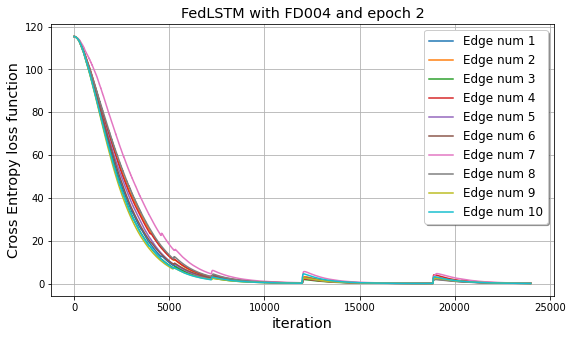

In [39]:
num_workers = 10
iteration_epoch = 3000
epoch = 2
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD004 and epoch 2", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD004_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD004/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD004_epoch_2))
plt.savefig('J_FD004_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD004_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\alibei\AppData\Local\Temp/ipykernel_5396/4023107890.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


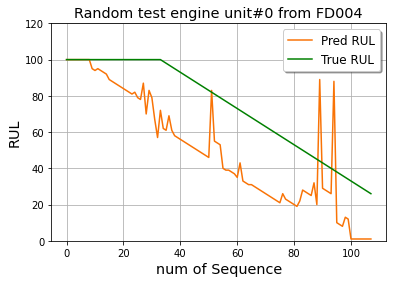

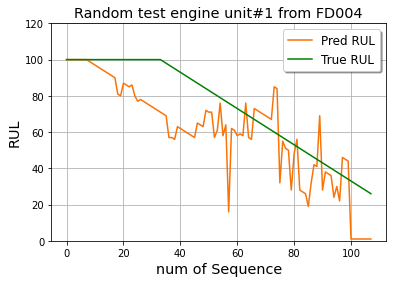

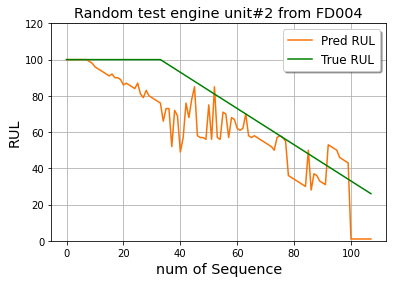

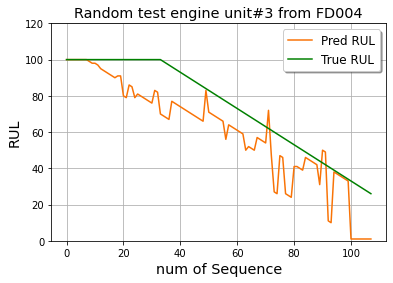

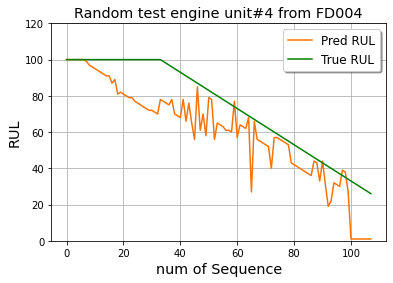

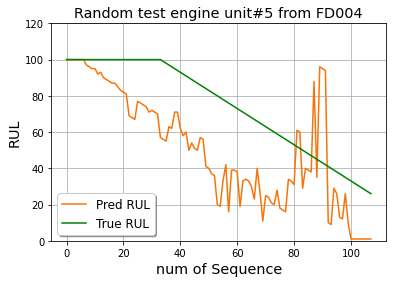

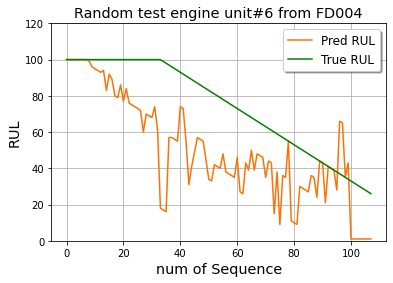

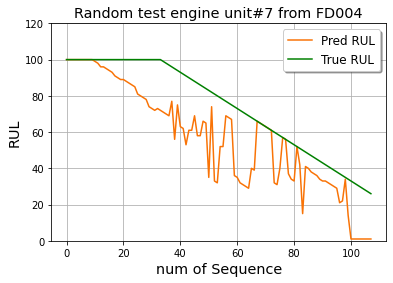

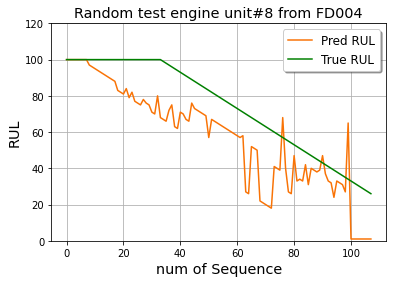

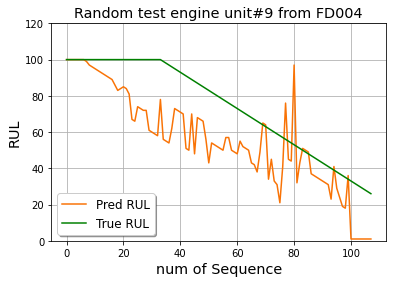

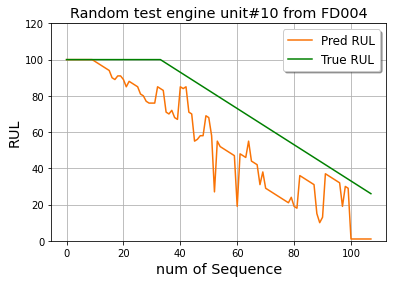

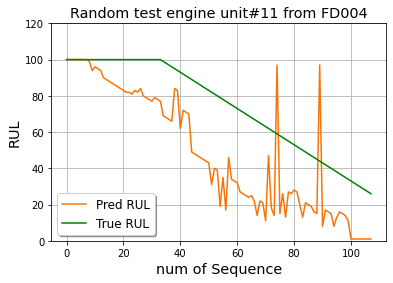

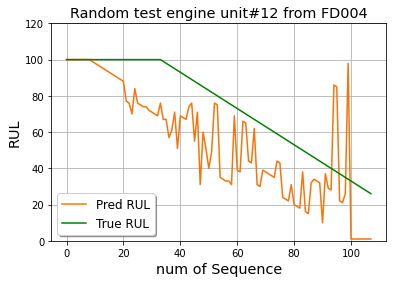

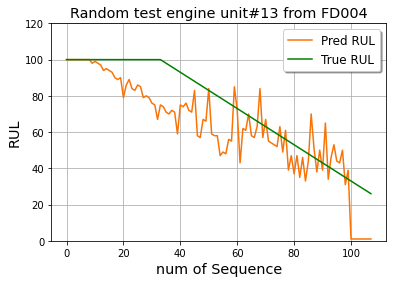

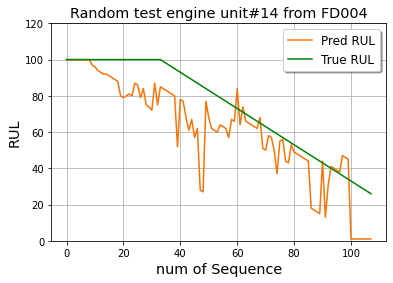

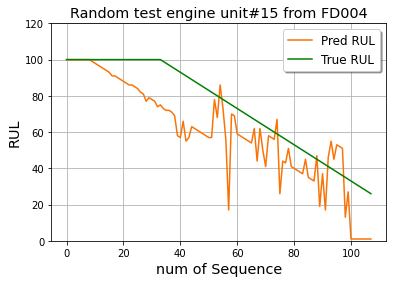

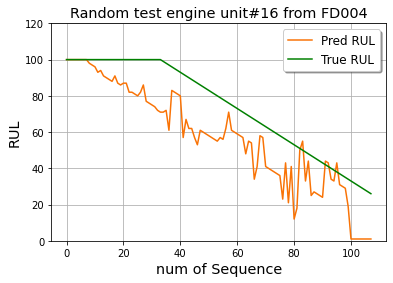

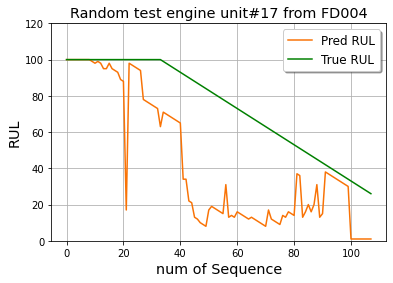

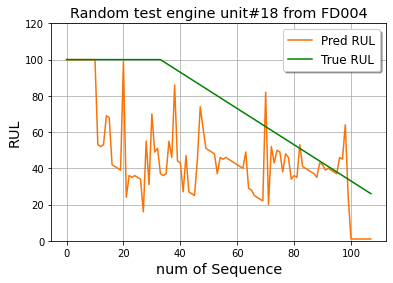

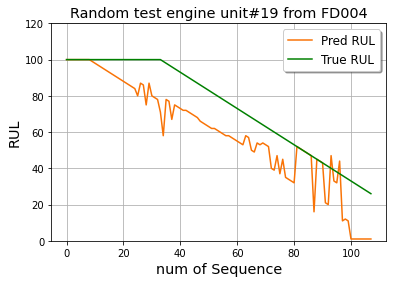

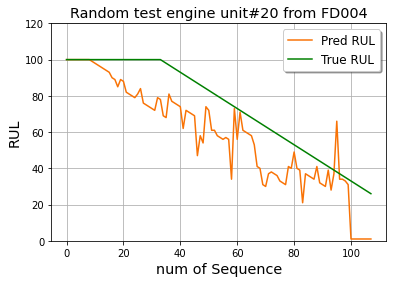

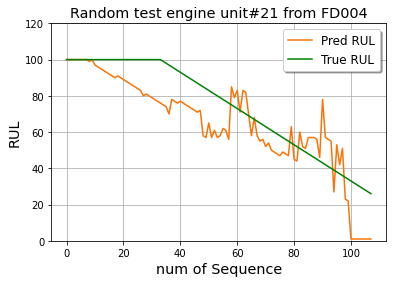

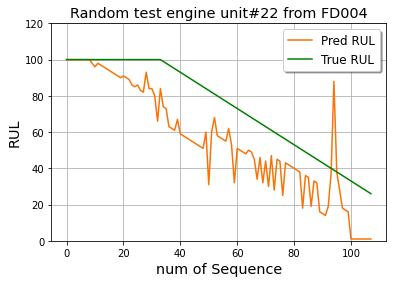

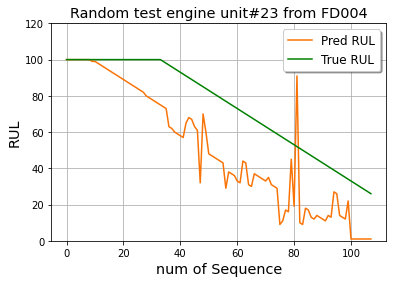

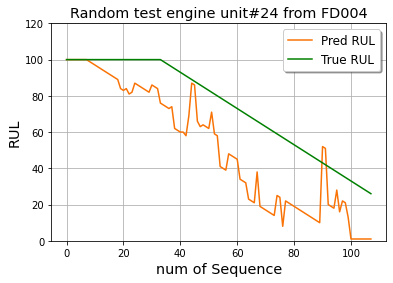

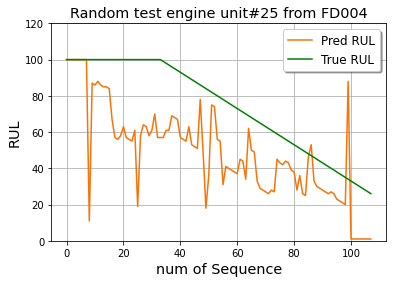

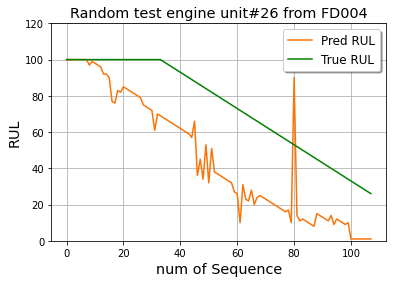

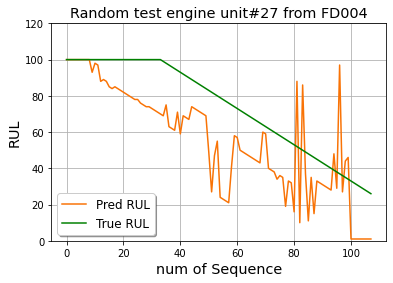

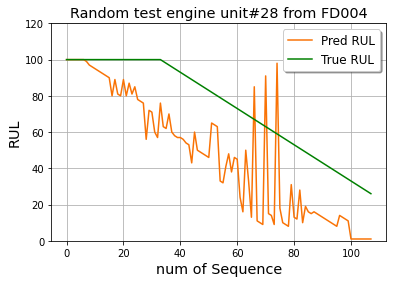

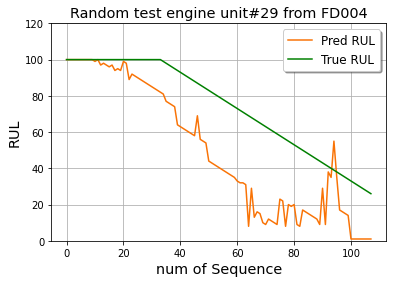

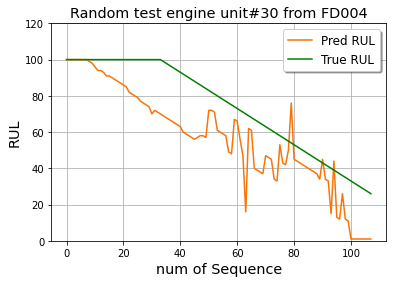

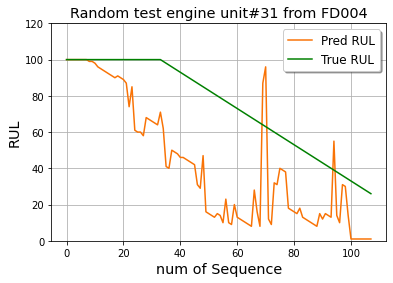

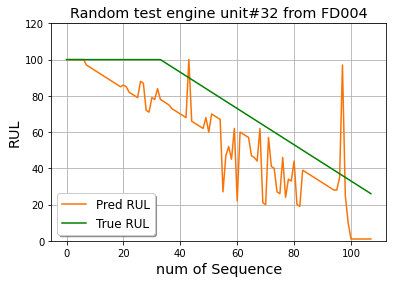

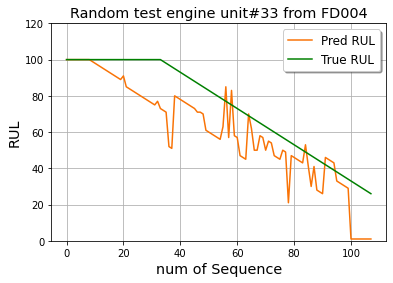

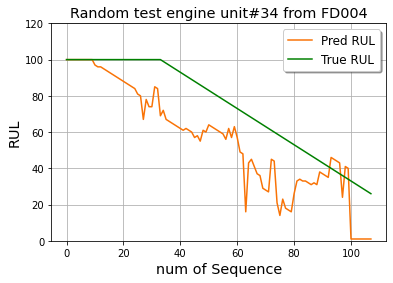

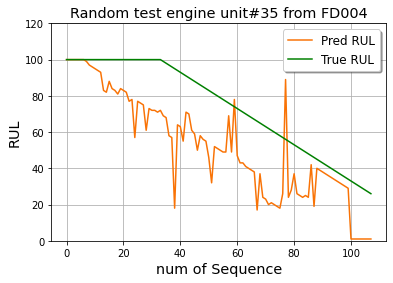

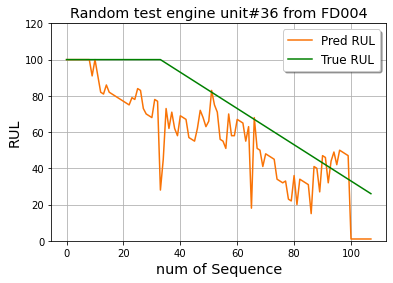

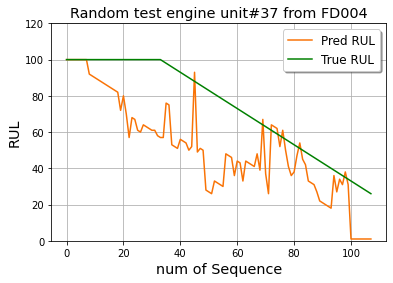

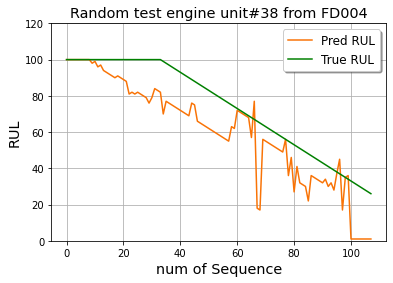

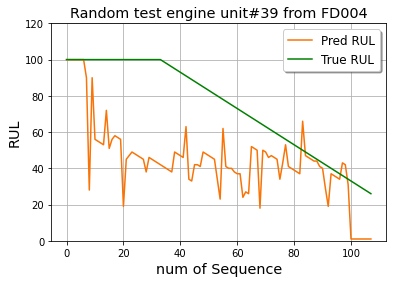

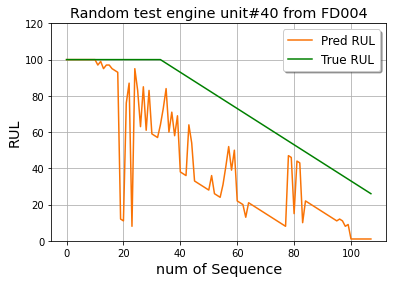

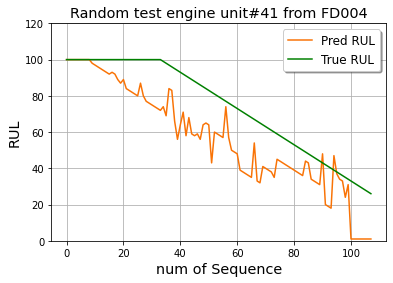

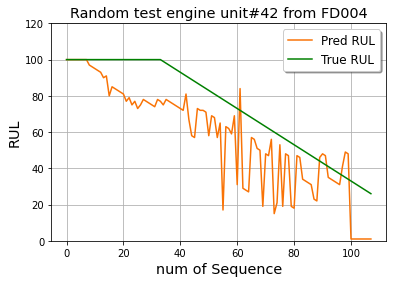

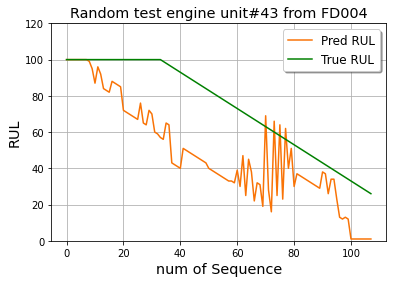

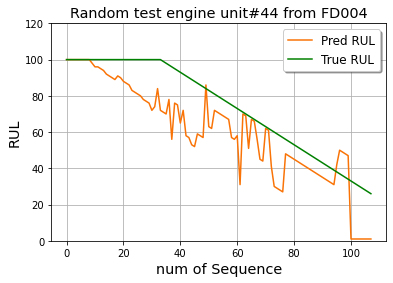

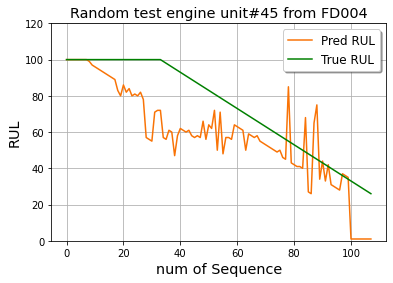

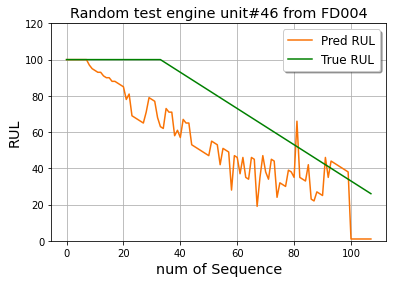

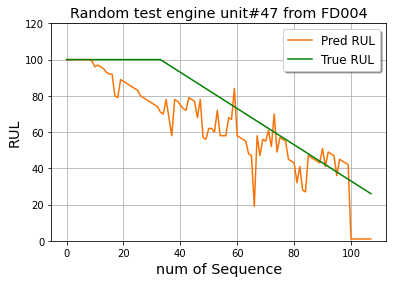

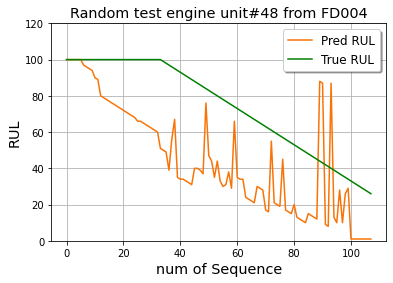

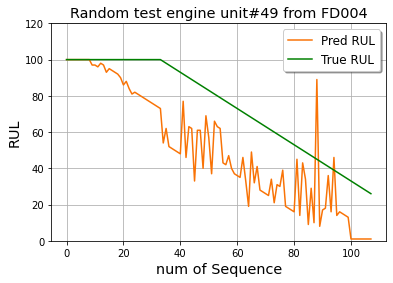

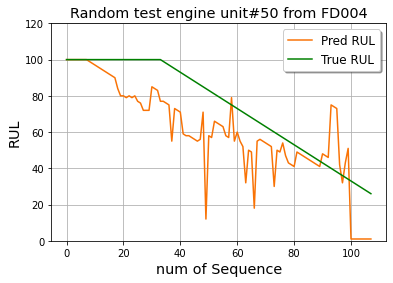

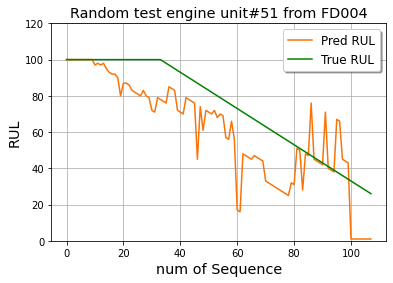

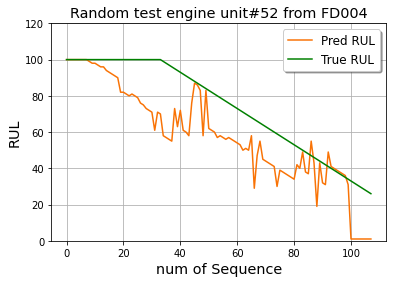

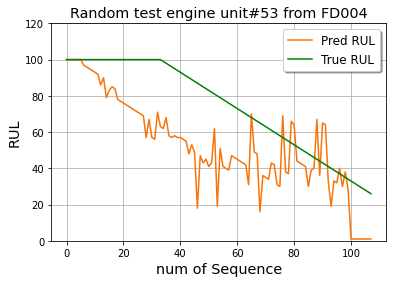

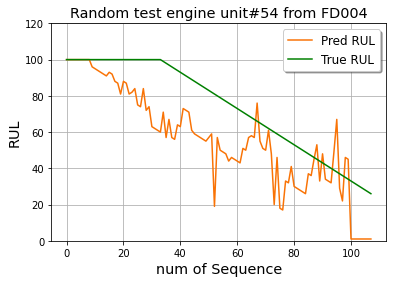

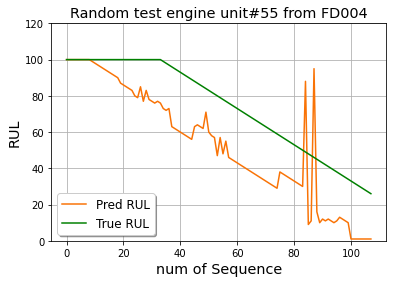

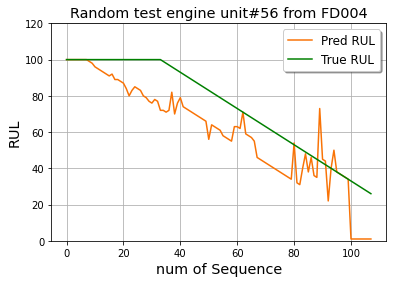

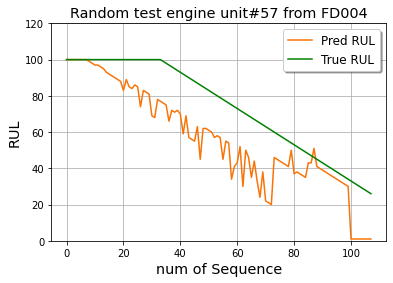

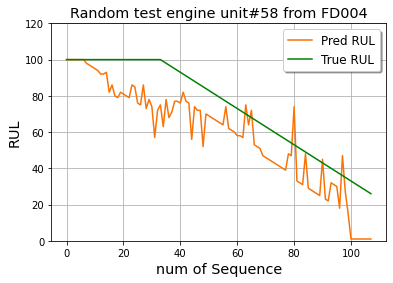

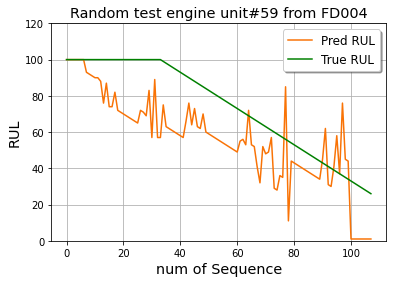

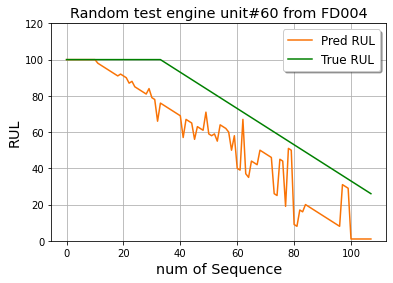

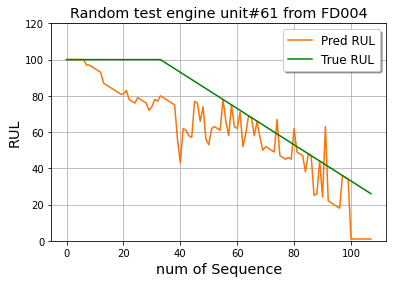

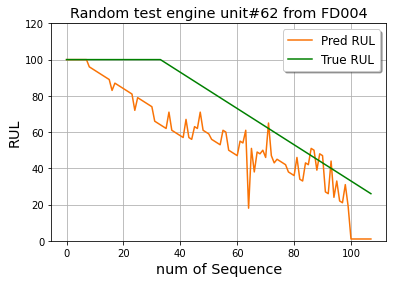

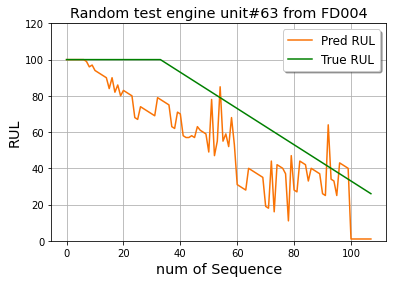

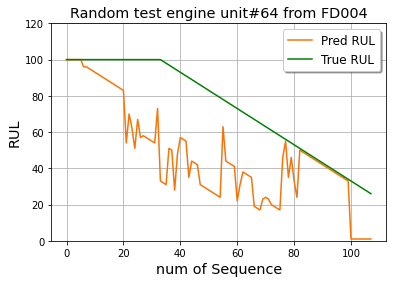

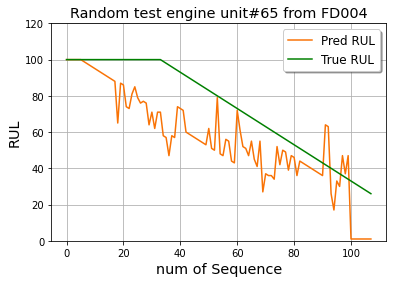

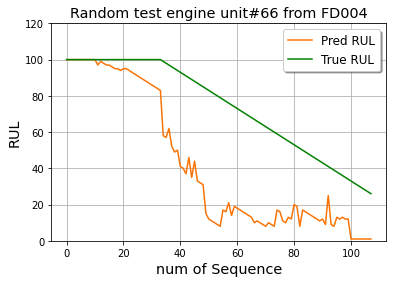

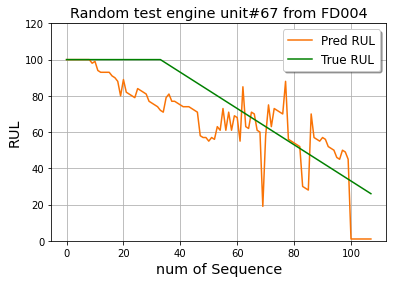

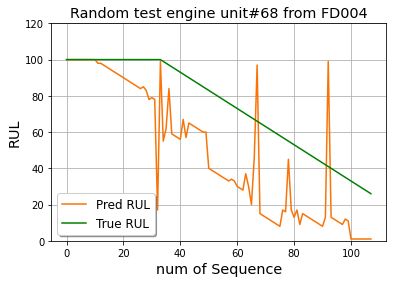

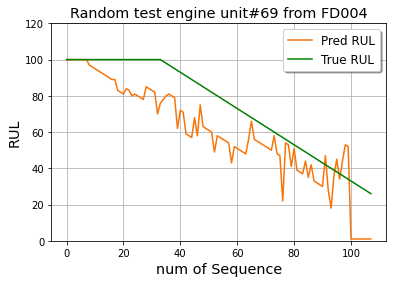

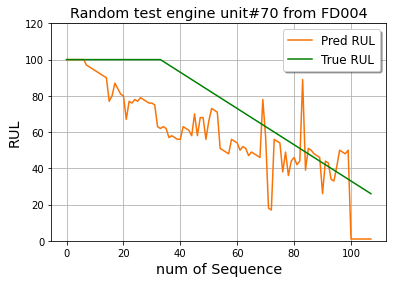

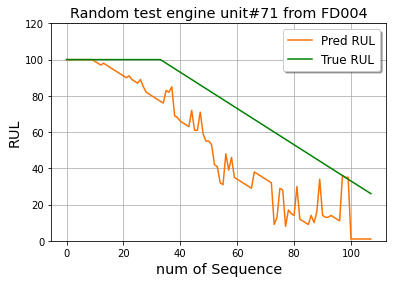

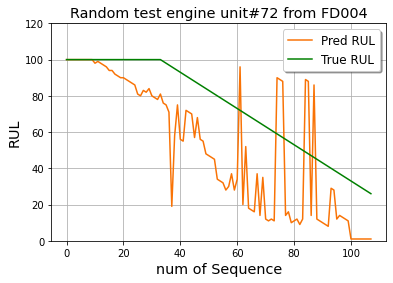

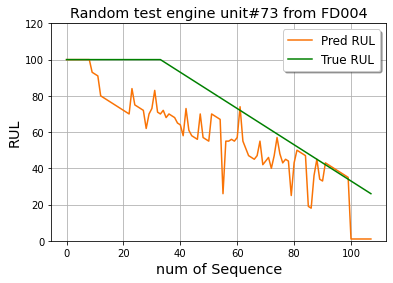

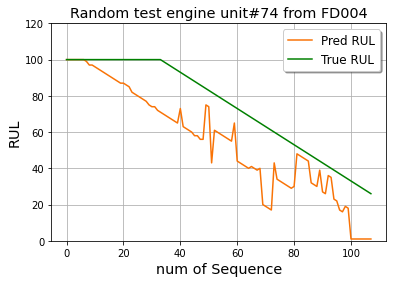

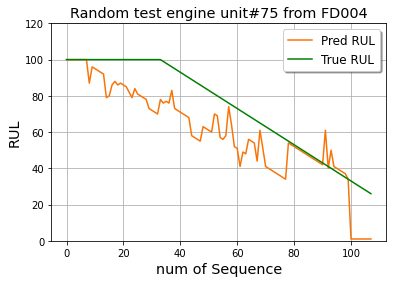

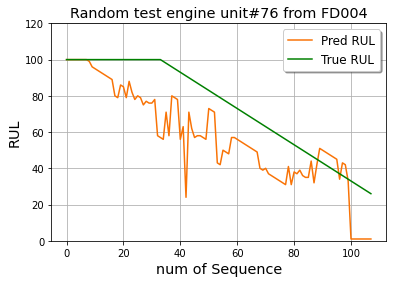

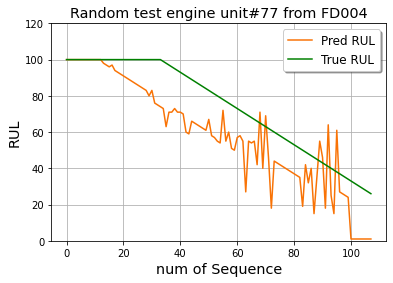

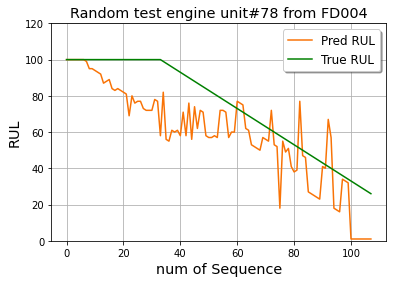

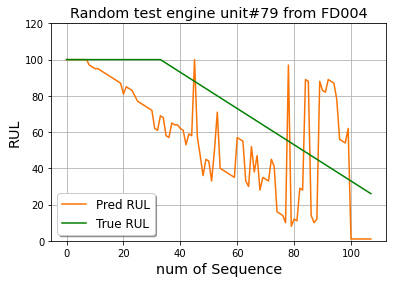

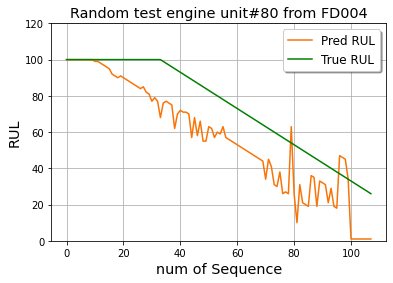

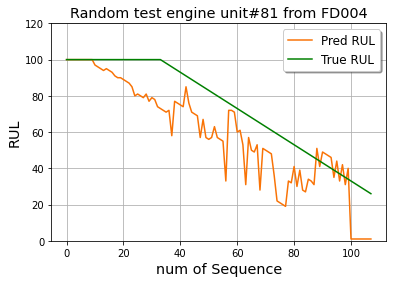

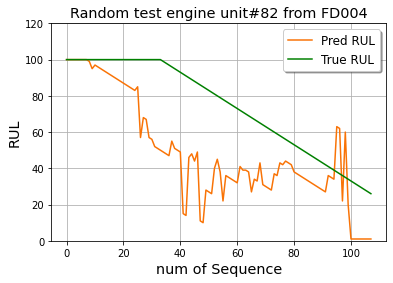

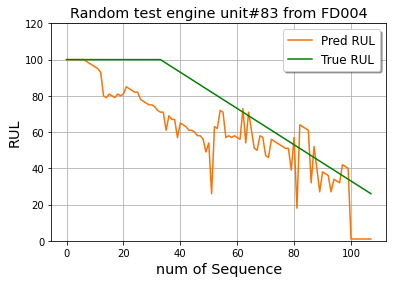

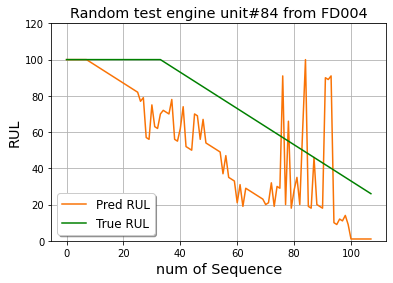

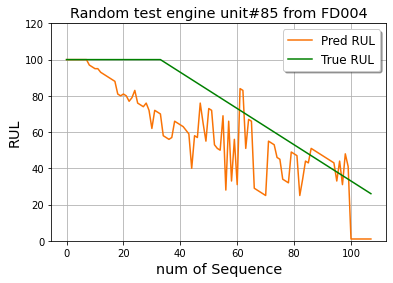

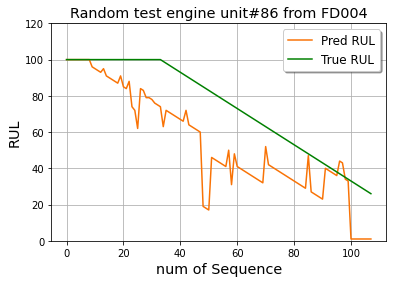

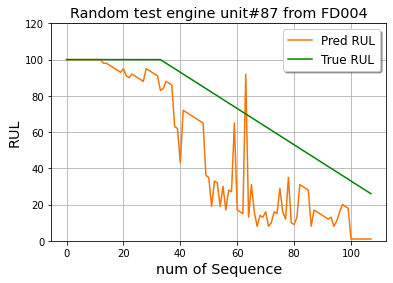

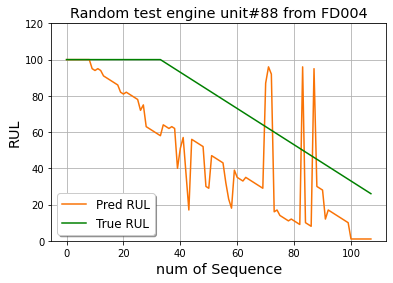

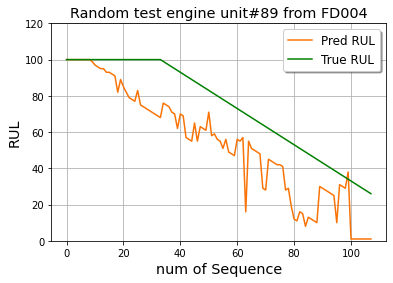

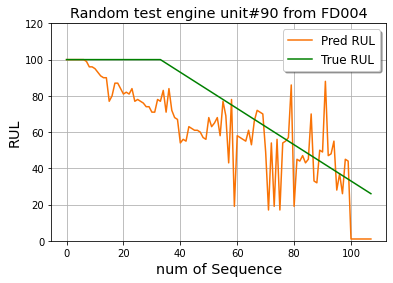

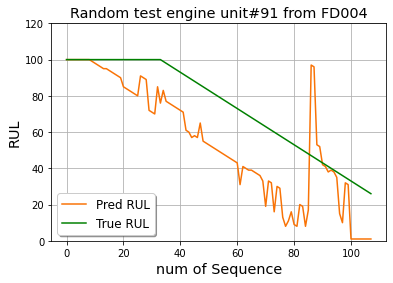

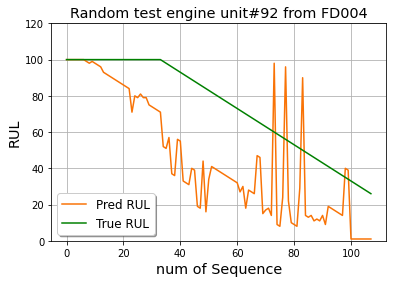

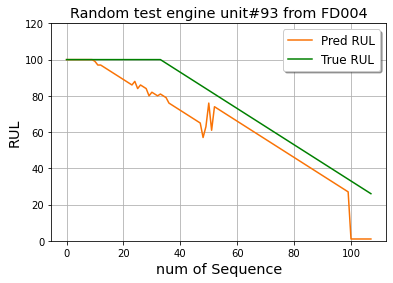

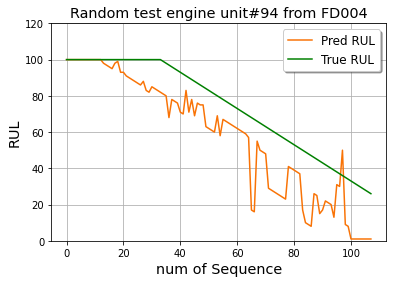

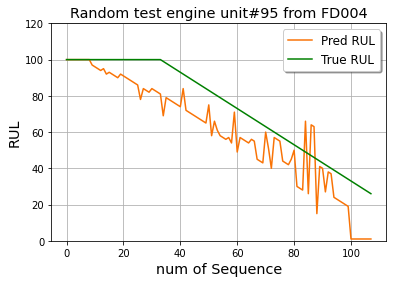

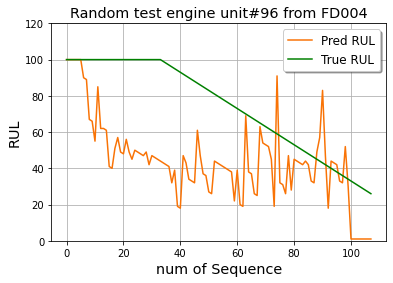

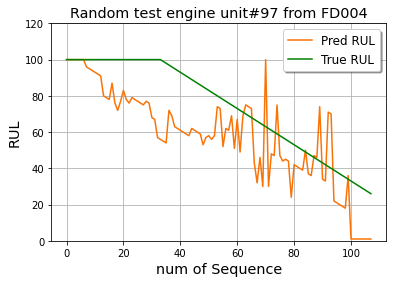

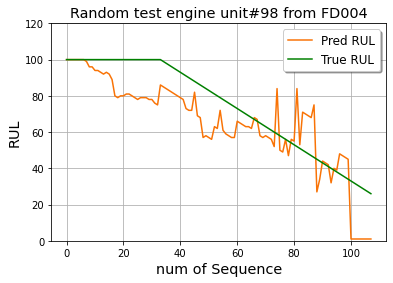

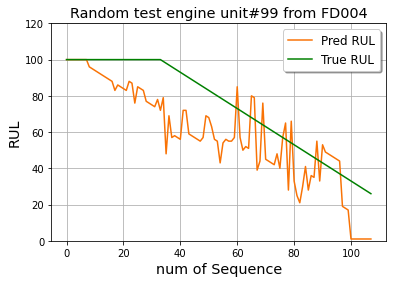

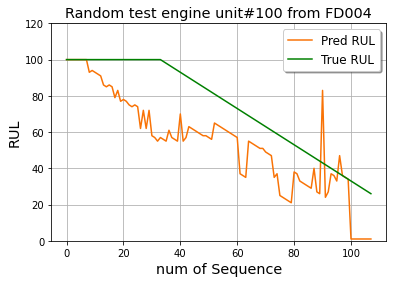

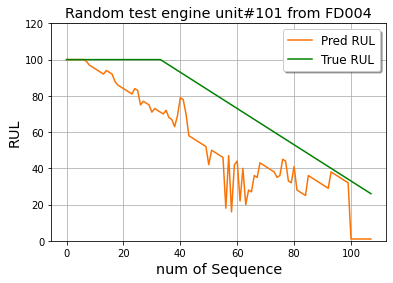

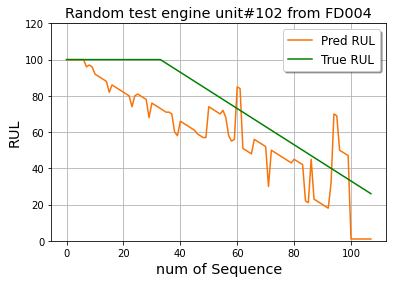

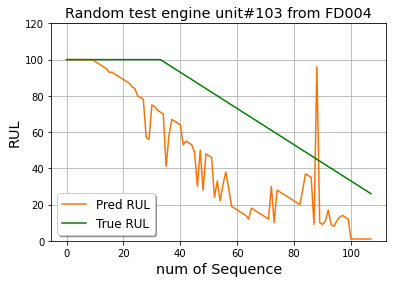

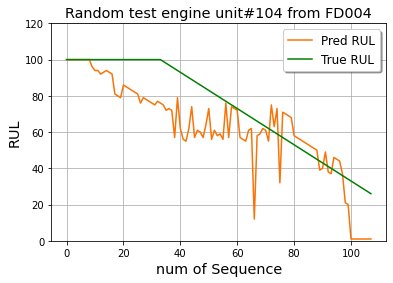

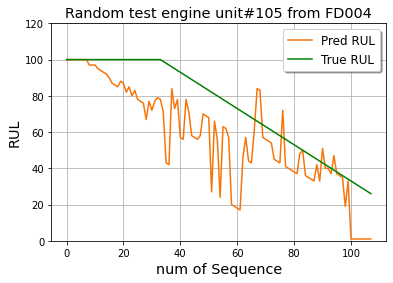

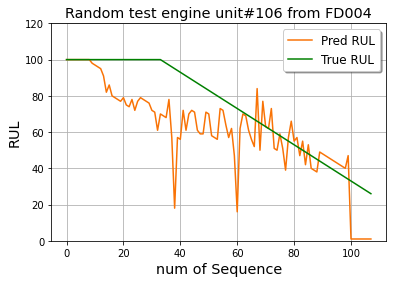

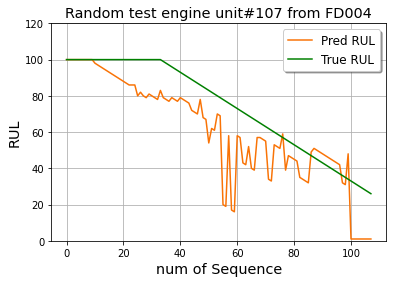

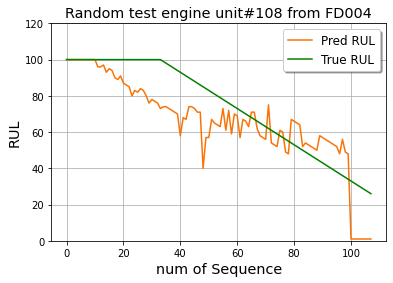

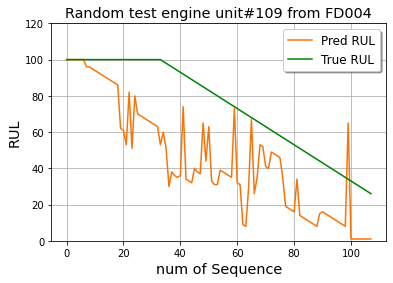

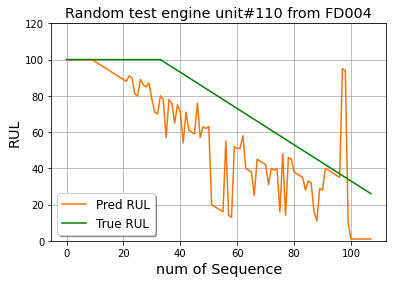

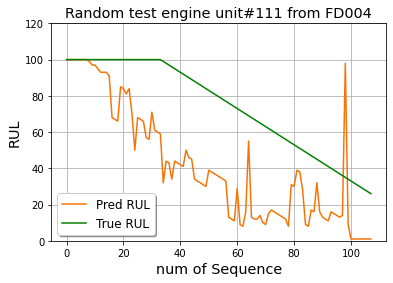

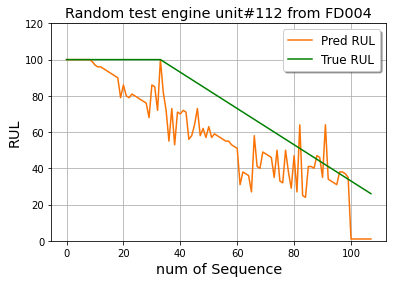

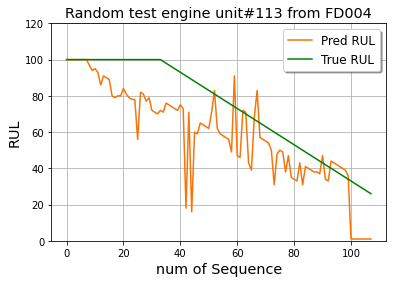

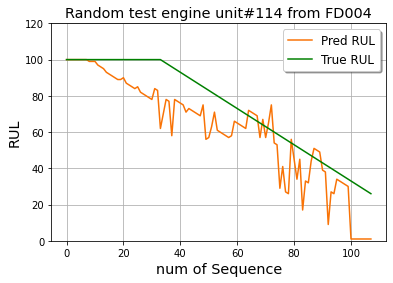

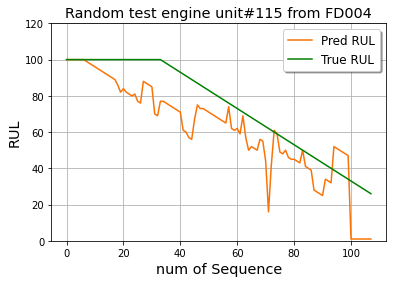

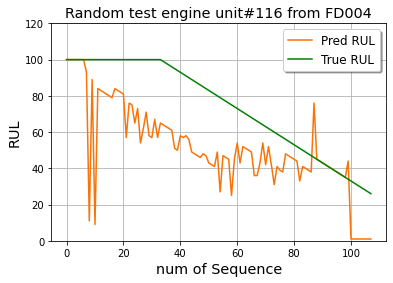

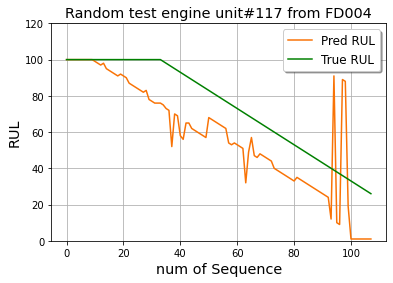

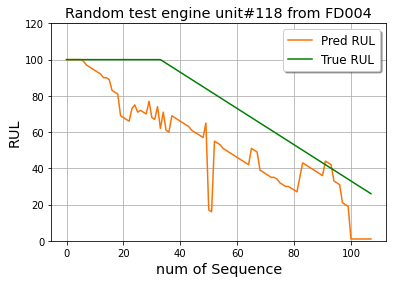

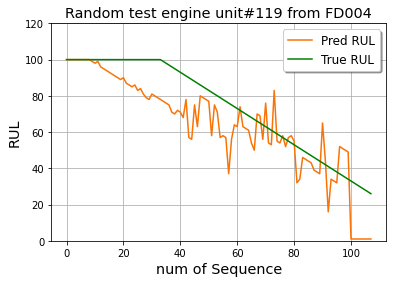

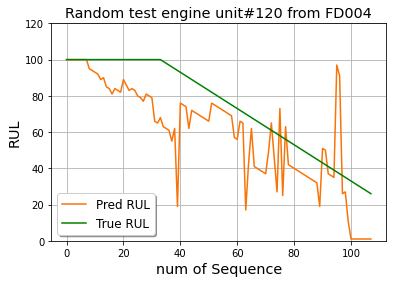

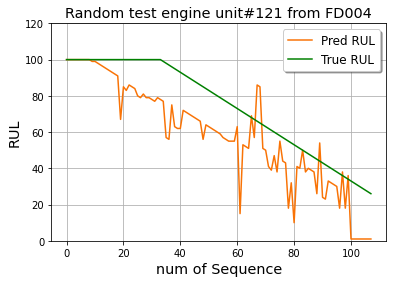

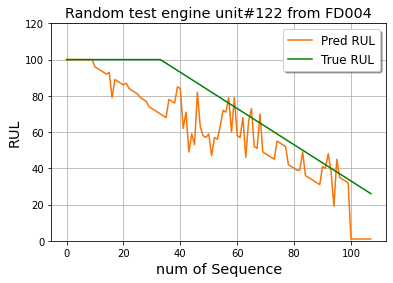

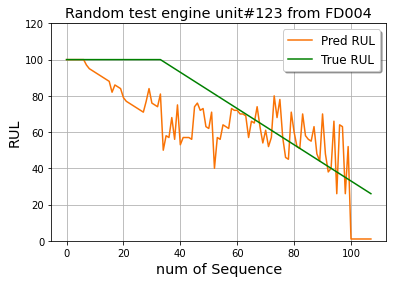

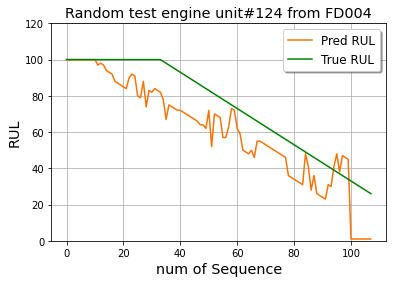

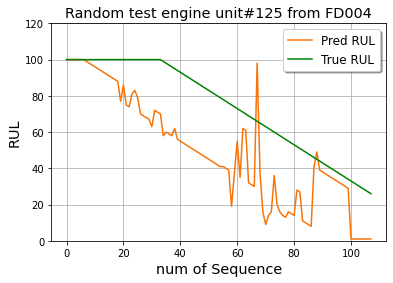

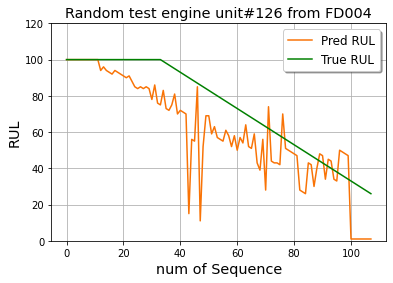

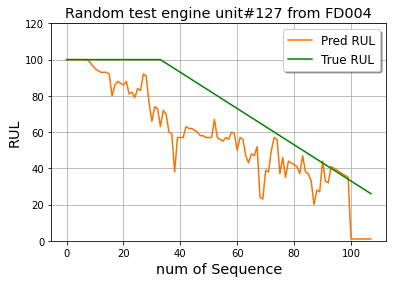

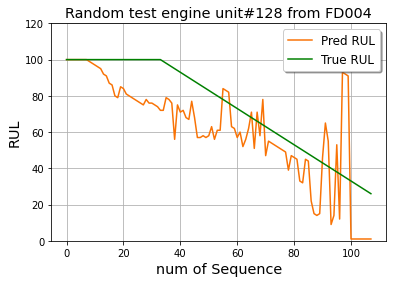

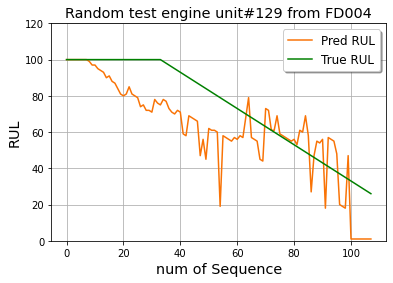

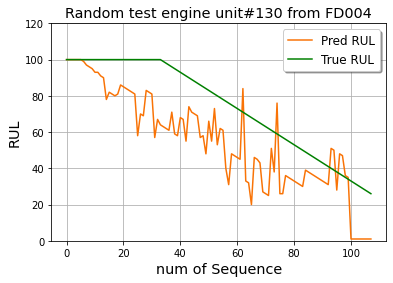

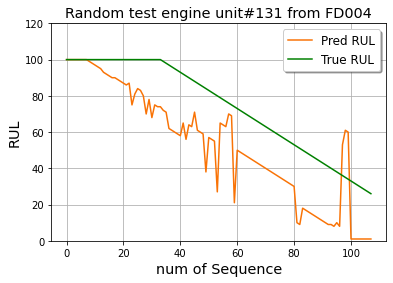

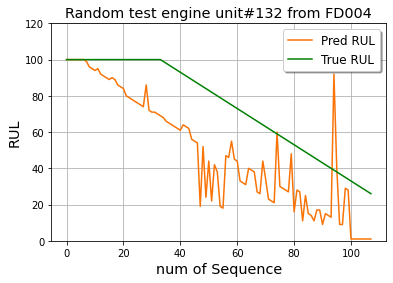

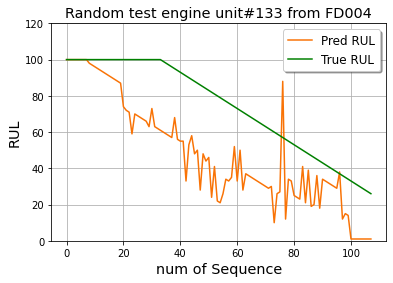

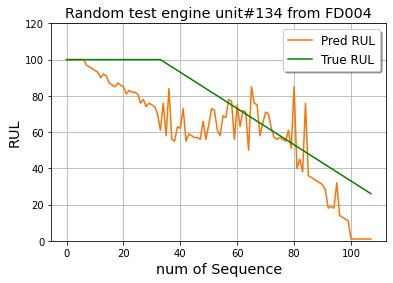

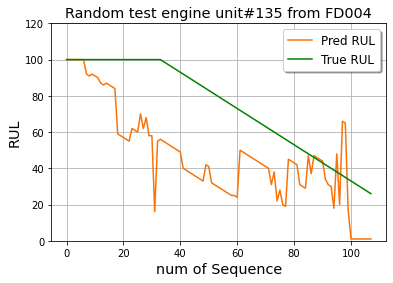

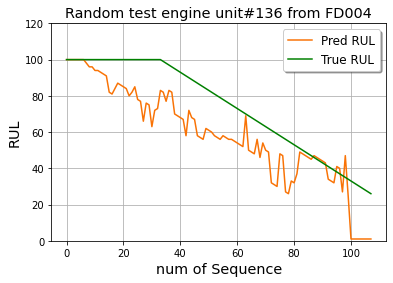

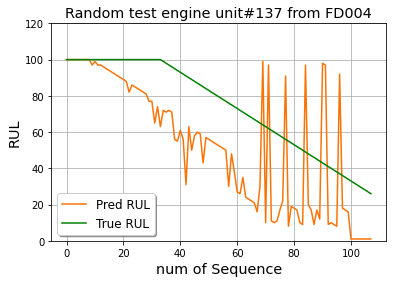

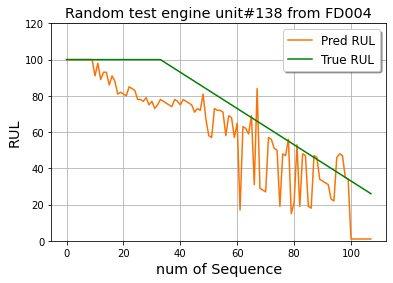

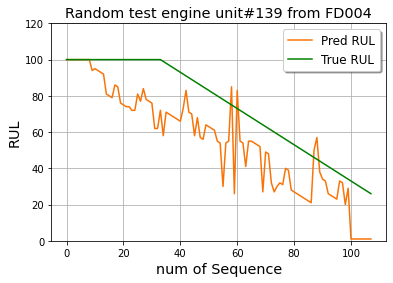

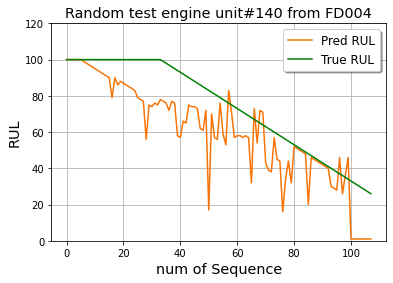

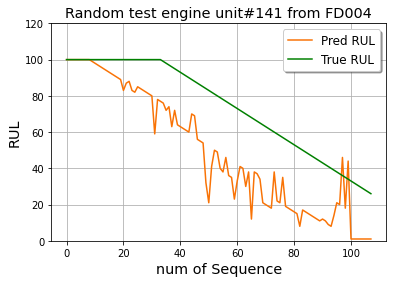

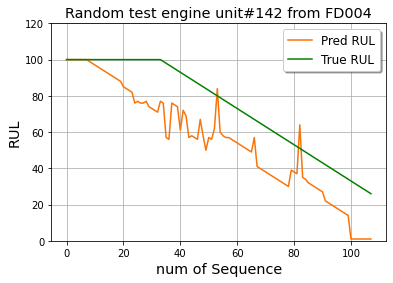

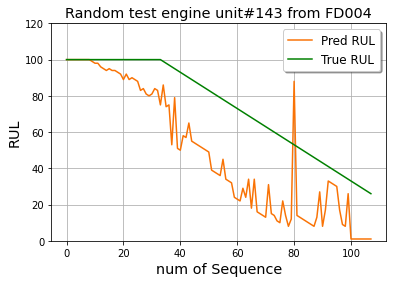

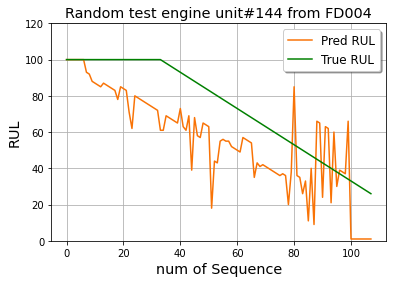

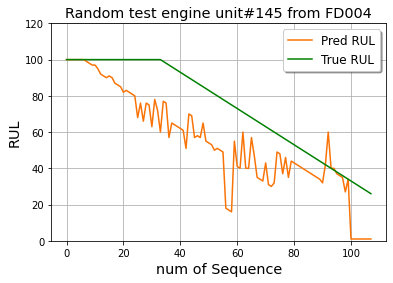

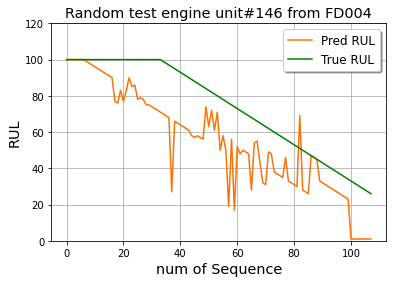

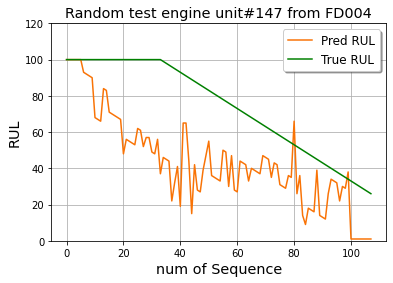

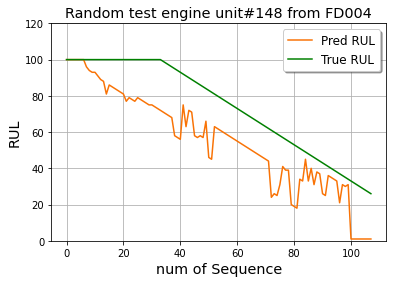

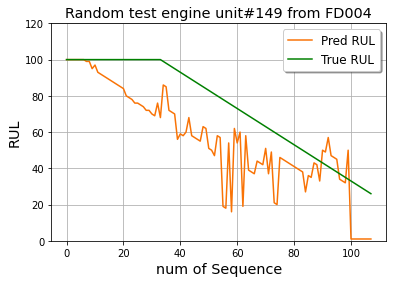

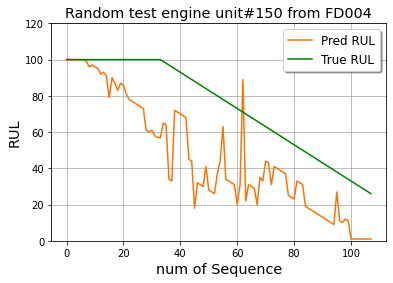

In [42]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD004", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD004/Results/epoch_2/"
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".png", format='png', dpi=1200)

In [43]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD004/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[13].savefig("FD004 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(13) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[13].savefig("FD004 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(13) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[37.50238833]


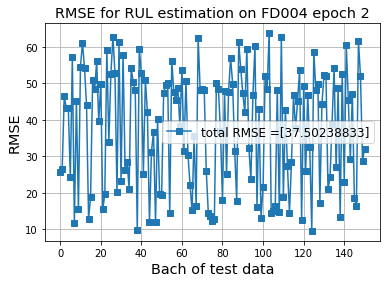

In [41]:
# RMSE and Scoring factor epoch 2
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD004 epoch 2", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()

RMSE_epoch_2 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_2))

plt.legend(labels, loc='best', fontsize='large')


print(RMSE_epoch_2)
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD004 epoch 2.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD004 epoch 2.png", format='png', dpi=1200, bbox_inches='tight')

[ 2.56010835e+02 -6.58134280e+01 -8.55473510e+01 -8.55433241e+01
 -8.77674514e+01  1.97296791e+03 -9.10112001e+01  5.73034343e+01
 -8.80889757e+01  3.43908222e+02 -8.49466479e+01 -8.75225901e+01
 -8.60932131e+01 -8.41841004e+01  9.27197051e+01 -4.15979283e+01
 -8.76246787e+01 -8.15919496e+01 -9.37061010e+01 -8.45537082e+01
 -8.63780955e+01  6.94865559e+02  1.34097595e+02 -8.58243700e+01
 -8.17769698e+01 -9.30972834e+01 -8.95588313e+01 -8.81959039e+01
  2.88276935e+02 -8.21713167e+01 -6.82511218e+01 -8.80433180e+01
  1.21353322e+02 -7.97386315e+01 -5.99541001e+01 -9.06890315e+01
 -9.02198645e+01 -9.24700466e+01  8.10891987e+01 -9.85426284e+01
 -8.69986302e+01 -7.62717113e+01 -8.85693812e+01 -8.93421529e+01
  6.57050973e+01 -7.78975707e+01 -8.61874543e+01  9.32262330e+01
  4.39365889e+01  1.86624224e+02  9.20318206e+01 -8.41926960e+01
 -8.69181880e+01 -9.28015159e+01  1.35333827e+02 -8.60853841e+01
 -8.62607642e+01 -8.66710453e+01 -8.79936920e+01 -8.71180014e+01
 -8.49473462e+01 -8.48835

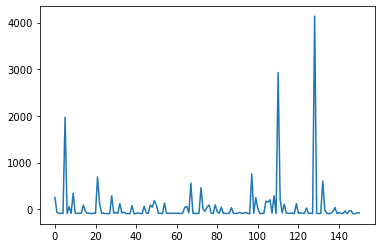

In [48]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

## Load Cost functions and Parameters

In [45]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD004_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD004/LogData/epoch_2/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD004_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD004_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[ 0.00554404,  0.00801827,  0.04039532, ...,  0.03075381,
         0.01649397,  0.028534  ],
       [ 0.06536521,  0.02680903,  0.05917578, ...,  0.04650089,
         0.02126123,  0.02292746],
       [ 0.04948358,  0.0788083 ,  0.04660124, ...,  0.01629125,
         0.01954676,  0.01820222],
       ...,
       [ 0.09889142,  0.02324028,  0.2350139 , ..., -0.10213331,
        -0.10318379, -0.07261542],
       [-0.01130275,  0.01350515,  0.01810031, ..., -0.01008909,
        -0.02255882, -0.02898577],
       [ 0.00712055, -0.09442947,  0.04983207, ..., -0.04767336,
         0.01503124, -0.00039279]]), 'bf': array([[1.04188448],
       [1.03044907],
       [1.03431261],
       [1.01082891],
       [1.02469544],
       [0.94237351],
       [1.01278554],
       [1.01778367],
       [1.04578219],
       [1.04946732],
       [1.05046786],
       [1.03212717],
       [1.0225675 ],
       [1.04281813],
       [1.03123799],
       [1.04484594],
       [1.00701034],
       [1.00691